In [2]:
import requests
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
from config import api_key, fbi_key,pword
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 999)

In [174]:
#create quartile band fxn
def quartile_band(df):
    global top_25
    global top_50
    global top_75
    top_25 = round(len(df)*0.25)
    top_50 = round(len(df)*0.5)
    top_75 = round(len(df)*0.75)
    

In [231]:
#get zip code data for zip codes with totals in the top 3 quartiles
def zip_gen(length, pre):
    prefix = pre
    suffix = 'E'
    nums = [str(x).zfill(3) for x in range(1,length+1)]
    #create indicator list
    indic = [prefix+x+suffix for x in nums]
    features = ''
    for y in indic:
        features = features + ','+ y
    url = f'https://api.census.gov/data/2018/acs/acs5?get=NAME{features}&for=zip%20code%20tabulation%20area:*&key={api_key}'
    print(url)
    #get response
    response = requests.get(url)
    print(response)
    #jsonify
    response=response.json()
    global zip_df
    #create zip_df
    zip_df = pd.DataFrame(response)
    #set column names
    zip_df.columns = zip_df.iloc[0]
    #remove first row
    zip_df = zip_df.iloc[1:]
    #get col list from census_df
    col_list = list(zip_df.columns)
    new_names = []
    #get label names and append to new_names list
    for x in col_list:
        if x not in label_df['name'].values:
            new_names.append(x)
        else:
            for i in range(len(label_df)):
                if label_df.loc[i,'name'] == x:
                    new_names.append(label_df.loc[i,'label'])
                    break
    #replace census_df column names
    zip_df.columns = new_names
    #convert obects to int
    col_list_2 = new_names[1:]
    try:
        for col in col_list2:
            zip_df[col] = zip_df[col].astype(int)
    except: 
        print('error in object conversion')
    #remove zip codes with no responses 
    zip_df= zip_df[zip_df['Estimate!!Total'] != 0]
    #sort by estimate total
    zip_df.sort_values(by=['Estimate!!Total'], inplace=True, ascending=False)
    zip_df.reset_index(inplace=True, drop=True)
    #create quartile bands 
    quartile_band(zip_df)
    #get top 75% of Total column
    zip_df = zip_df.iloc[:top_75]
    return zip_df.head()


In [19]:
#define feature generator for url api call
def feature_gen(length,pre):
    #get numbers for indicator range
    nums = [str(x).zfill(3) for x in range(1,length+1)]
    prefix = pre
    suffix = 'E'
    #create indicator list
    indic = [prefix+x+suffix for x in nums]
    #add to string
    features = ''
    #add to url string
    for y in indic:
        features = features + ','+ y
    url = f'https://api.census.gov/data/2018/acs/acs5?get=NAME{features}&for=us:*&key={api_key}'
    print(url)
    #get response
    response = requests.get(url)
    print(response)
    #jsonify
    response=response.json()
    global census_df
    #create census_df
    census_df = pd.DataFrame(response)
    census_df.head()
    #set column names
    census_df.columns = census_df.iloc[0]
    #remove first row
    census_df = census_df.iloc[1:]
    #get col list from census_df
    col_list = list(census_df.columns)
    new_names = []
    #get label names and append to new_names list
    for x in col_list:
        if x not in label_df['name'].values:
            new_names.append(x)
        else:
            for i in range(len(label_df)):
                if label_df.loc[i,'name'] == x:
                    new_names.append(label_df.loc[i,'label'])
                    break
    #replace census_df column names
    census_df.columns = new_names
    #transpose df
    df1 = census_df.transpose()
    #re-format table with Owner occupied labels
    try:
        #drop unused rows
        df1.drop(['NAME','Estimate!!Total','Estimate!!Total!!Owner occupied',
                  'Estimate!!Total!!Renter occupied', 'us'], inplace=True)
        #strip un-needed strings
        categories = [x.lstrip('Estimate!!Total!!Owner occupied!!Householder').lstrip('Renter occupied!!Householder')
                      for x in df1.index]
        #create list of unique categories
        cats = []
        for x in categories:
            if x not in cats:
                cats.append(x)
        #create list for owners and renters
        rent = []
        own = []
        for x in df1.index:
            if "!!Owner occupied!!" in x:
                own.append(int(df1.loc[x,1]))
            elif "!!Renter occupied!!" in x:
                rent.append(int(df1.loc[x,1]))
        #create dictionary of categories, owners and renters
        dict_df = {'Category': cats,
                   'Own': own,
                   'Rent': rent}
        #create df
        census_df = pd.DataFrame(dict_df)
        #add Total, %Own and %Rent columns
        census_df['Total'] = census_df['Own'] + census_df['Rent']
        census_df['%Own'] = (census_df['Own']/census_df['Total'])*100
        census_df['%Rent'] = (census_df['Rent']/census_df['Total'])*100
    #Do the same for table with Owner-occupied labels    
    except:
        df1.drop(['NAME','Estimate!!Total','Estimate!!Total!!Owner-occupied housing units',
                  'Estimate!!Total!!Renter-occupied housing units', 'us'], inplace=True)
        categories = [x.lstrip('Estimate!!Total!!Owner-occupied housing units!!').lstrip(
            'Estimate!!Total!!Renter-occupied housing units!!') for x in df1.index]
        cats = []
        for x in categories:
            if x not in cats:
                cats.append(x)
        rent = []
        own = []
        for x in df1.index:
            if "!!Owner-occupied housing units!!" in x:
                own.append(int(df1.loc[x,1]))
            elif "Renter-occupied housing units!!" in x:
                rent.append(int(df1.loc[x,1]))
        dict_df = {'Category': cats,
                   'Own': own,
                   'Rent': rent}
        census_df = pd.DataFrame(dict_df)
        census_df['Total'] = census_df['Own'] + census_df['Rent']
        census_df['%Own'] = (census_df['Own']/census_df['Total'])*100
        census_df['%Rent'] = (census_df['Rent']/census_df['Total'])*100
        

    return census_df.head()



In [5]:
def get_chart(df, title, degree):
    fig, ax = plt.subplots(figsize=(20,12))
    
    N = len(df)

    ind = np.arange(N)    # the x locations for the groups
    width = 0.35        # the width of the bars
    own = ax.bar(ind, df['%Own'], width, label ='%Own')
    rent = ax.bar(ind + width, df['%Rent'], width, label ='%Rent', color = 'Red')

    ax.set_title(f'Rent vs Own by {title}', fontsize=20)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(df['Category'], rotation = degree)

    ax.legend(fontsize=20)
    ax.set_xlabel(f'{title}', fontsize=20)
    ax.set_ylabel('Percent', fontsize=20)
    ax.tick_params(axis='both', labelsize=16)

    for i, v in enumerate(df['%Own']):
        ax.text(i - .2, v + 2, format(v,'.1f') +'%', fontsize = 16)

    for i, v in enumerate(df['%Rent']):
        ax.text(i + .2, v + 2, format(v,'.1f') + '%', fontsize = 16)

    plt.tight_layout()
    plt.savefig(f"images/{title}.png")
    plt.show()

In [6]:
#create label table
label_url = 'https://api.census.gov/data/2018/acs/acs5/variables'
label_response = requests.get(label_url)
print(label_response)
label_response = label_response.json()
label_df = pd.DataFrame.from_records(label_response)

label_df.columns = label_df.iloc[0]
label_df = label_df.iloc[4:]
label_df.reset_index(inplace=True, drop=True)
label_df.head()

<Response [200]>


,name,label,concept
0,B24022_060E,Estimate!!Total!!Female!!Service occupations!!...,SEX BY OCCUPATION AND MEDIAN EARNINGS IN THE P...
1,B19001B_014E,"Estimate!!Total!!$100,000 to $124,999",HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 201...
2,B07007PR_019E,Estimate!!Total!!Moved from different municipi...,GEOGRAPHICAL MOBILITY IN THE PAST YEAR BY CITI...
3,B19101A_004E,"Estimate!!Total!!$15,000 to $19,999",FAMILY INCOME IN THE PAST 12 MONTHS (IN 2018 I...
4,B24022_061E,Estimate!!Total!!Female!!Service occupations!!...,SEX BY OCCUPATION AND MEDIAN EARNINGS IN THE P...


In [20]:
#get household data by age
feature_gen(21,'B25007_')

https://api.census.gov/data/2018/acs/acs5?get=NAME,B25007_001E,B25007_002E,B25007_003E,B25007_004E,B25007_005E,B25007_006E,B25007_007E,B25007_008E,B25007_009E,B25007_010E,B25007_011E,B25007_012E,B25007_013E,B25007_014E,B25007_015E,B25007_016E,B25007_017E,B25007_018E,B25007_019E,B25007_020E,B25007_021E&for=us:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>


,Category,Own,Rent,Total,%Own,%Rent
0,15 to 24 years,607410,3862720,4470130,13.588195,86.411805
1,25 to 34 years,6946746,11308267,18255013,38.053909,61.946091
2,35 to 44 years,11929967,8669582,20599549,57.913729,42.086271
3,45 to 54 years,15816417,7153044,22969461,68.858459,31.141541
4,55 to 59 years,8959219,3137380,12096599,74.063950,25.936050


In [339]:
age_df['Total'].sum()

119730128

In [338]:
age_df

,Category,Own,Rent,Total,%Own,%Rent
0,15 to 24 years,607410,3862720,4470130,13.588195,86.411805
1,25 to 34 years,6946746,11308267,18255013,38.053909,61.946091
2,35 to 44 years,11929967,8669582,20599549,57.913729,42.086271
3,45 to 54 years,15816417,7153044,22969461,68.858459,31.141541
4,55 to 59 years,8959219,3137380,12096599,74.063950,25.936050
5,60 to 64 years,8655435,2626313,11281748,76.720691,23.279309
6,65 to 74 years,13694250,3471817,17166067,79.775117,20.224883
7,75 to 84 years,7179740,1876192,9055932,79.282177,20.717823
8,85 years and over,2655626,1180003,3835629,69.235737,30.764263


In [8]:
age_df = census_df
age_df.to_csv('data/age.csv')

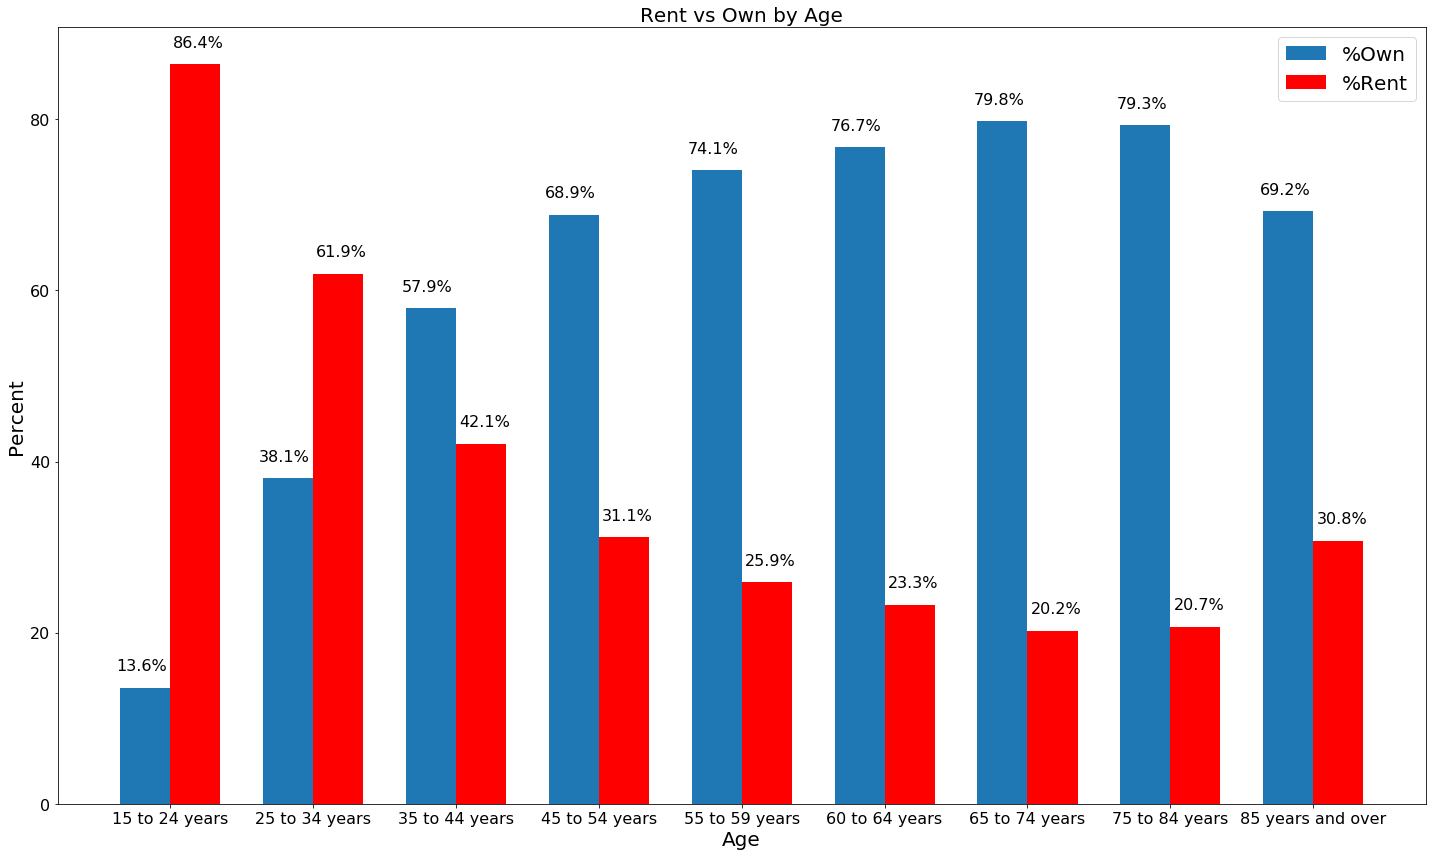

In [9]:
get_chart(age_df,'Age', 0)

In [21]:
#get size data
feature_gen(17,'B25009_')

https://api.census.gov/data/2018/acs/acs5?get=NAME,B25009_001E,B25009_002E,B25009_003E,B25009_004E,B25009_005E,B25009_006E,B25009_007E,B25009_008E,B25009_009E,B25009_010E,B25009_011E,B25009_012E,B25009_013E,B25009_014E,B25009_015E,B25009_016E,B25009_017E&for=us:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>


,Category,Own,Rent,Total,%Own,%Rent
0,1-person household,17343470,15868786,33212256,52.220090,47.779910
1,2-person household,28746125,11824177,40570302,70.855092,29.144908
2,3-person household,12162307,6597377,18759684,64.832153,35.167847
3,4-person household,10638861,4882103,15520964,68.545105,31.454895
4,5-person household,4731952,2453350,7185302,65.855993,34.144007


In [11]:
size_df = census_df
size_df.to_csv('data/size')

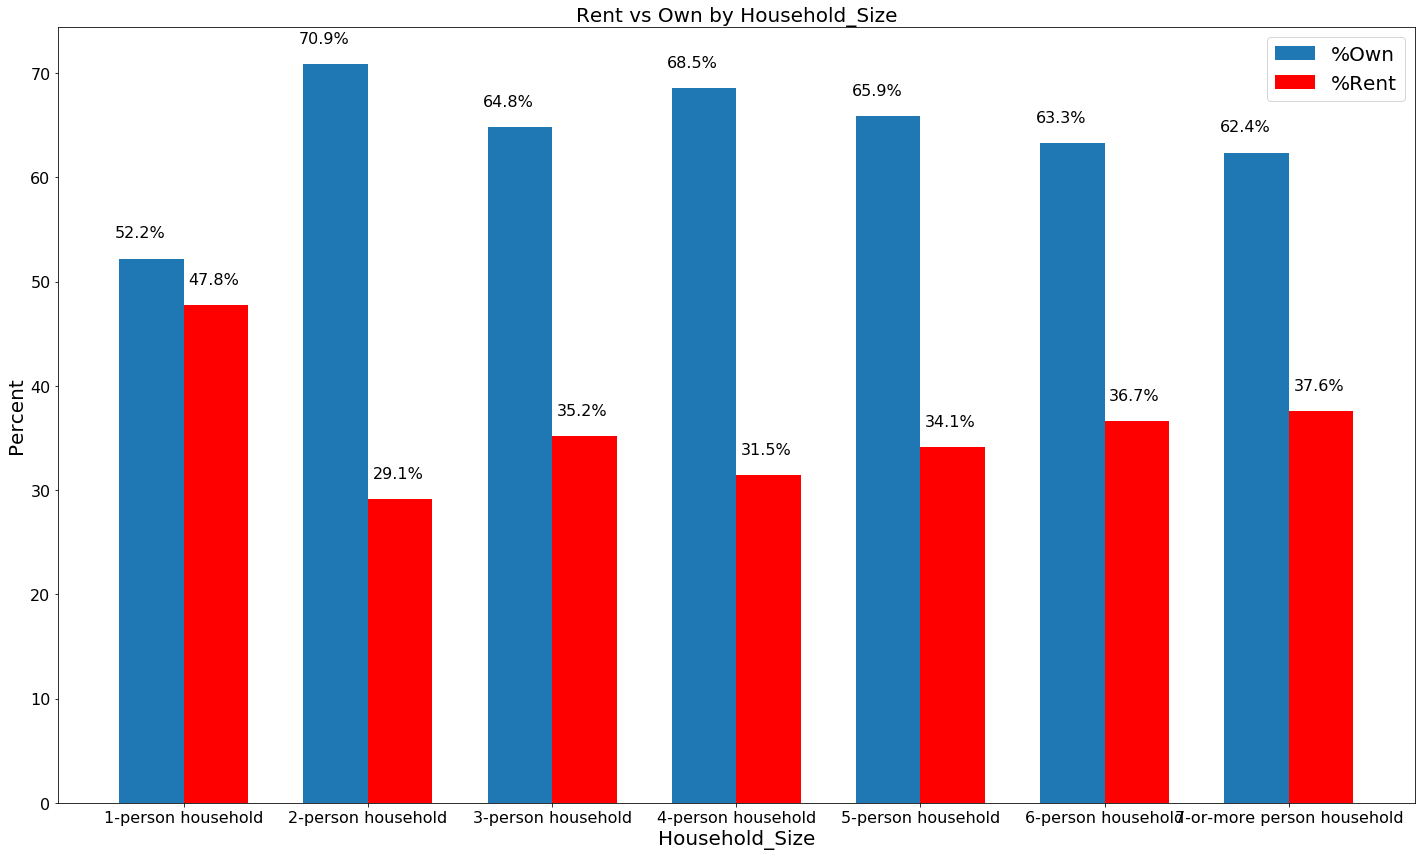

In [12]:
get_chart(size_df, 'Household_Size',0)

In [24]:
#get household type
feature_gen(49,'B25011_')

https://api.census.gov/data/2018/acs/acs5?get=NAME,B25011_001E,B25011_002E,B25011_003E,B25011_004E,B25011_005E,B25011_006E,B25011_007E,B25011_008E,B25011_009E,B25011_010E,B25011_011E,B25011_012E,B25011_013E,B25011_014E,B25011_015E,B25011_016E,B25011_017E,B25011_018E,B25011_019E,B25011_020E,B25011_021E,B25011_022E,B25011_023E,B25011_024E,B25011_025E,B25011_026E,B25011_027E,B25011_028E,B25011_029E,B25011_030E,B25011_031E,B25011_032E,B25011_033E,B25011_034E,B25011_035E,B25011_036E,B25011_037E,B25011_038E,B25011_039E,B25011_040E,B25011_041E,B25011_042E,B25011_043E,B25011_044E,B25011_045E,B25011_046E,B25011_047E,B25011_048E,B25011_049E&for=us:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>


,Category,Own,Rent,Total,%Own,%Rent
0,Family households,56066627,22630476,78697103,71.243572,28.756428
1,Family households!!Married-couple family,46051807,11765141,57816948,79.651051,20.348949
2,Family households!!Married-couple family!!Hous...,4540491,3800273,8340764,54.437351,45.562649
3,Family households!!Married-couple family!!Hous...,29622173,6713068,36335241,81.524636,18.475364
4,Family households!!Married-couple family!!Hous...,11889143,1251800,13140943,90.474047,9.525953


In [25]:
type_df = census_df
type_df.to_csv('data/type')

In [73]:

short = [x.lstrip('Family households!!').lstrip('Nonfamily households!!') for x in type_df['Category']]
type_df['Category'] = short

In [74]:
type_df

,Category,Own,Rent,Total,%Own,%Rent
0,,56066627,22630476,78697103,71.243572,28.756428
1,Married-couple family,46051807,11765141,57816948,79.651051,20.348949
2,Married-couple family!!Householder 15 to 34 years,4540491,3800273,8340764,54.437351,45.562649
3,Married-couple family!!Householder 35 to 64 years,29622173,6713068,36335241,81.524636,18.475364
4,Married-couple family!!Householder 65 years an...,11889143,1251800,13140943,90.474047,9.525953
5,Other family,10014820,10865335,20880155,47.963341,52.036659
6,"Other family!!Male householder, no wife present",3123184,2698791,5821975,53.644751,46.355249
7,"Other family!!Male householder, no wife presen...",504322,1070698,1575020,32.020038,67.979962
8,"Other family!!Male householder, no wife presen...",2024362,1470592,3494954,57.922422,42.077578
9,"Other family!!Male householder, no wife presen...",594500,157501,752001,79.055746,20.944254


In [75]:
young_df = type_df.iloc[[2,16,20]].reset_index(drop=True)
mid_df = type_df.iloc[[3,17,21]].reset_index(drop=True)
senior_df = type_df.iloc[[4,18,22]].reset_index(drop=True)

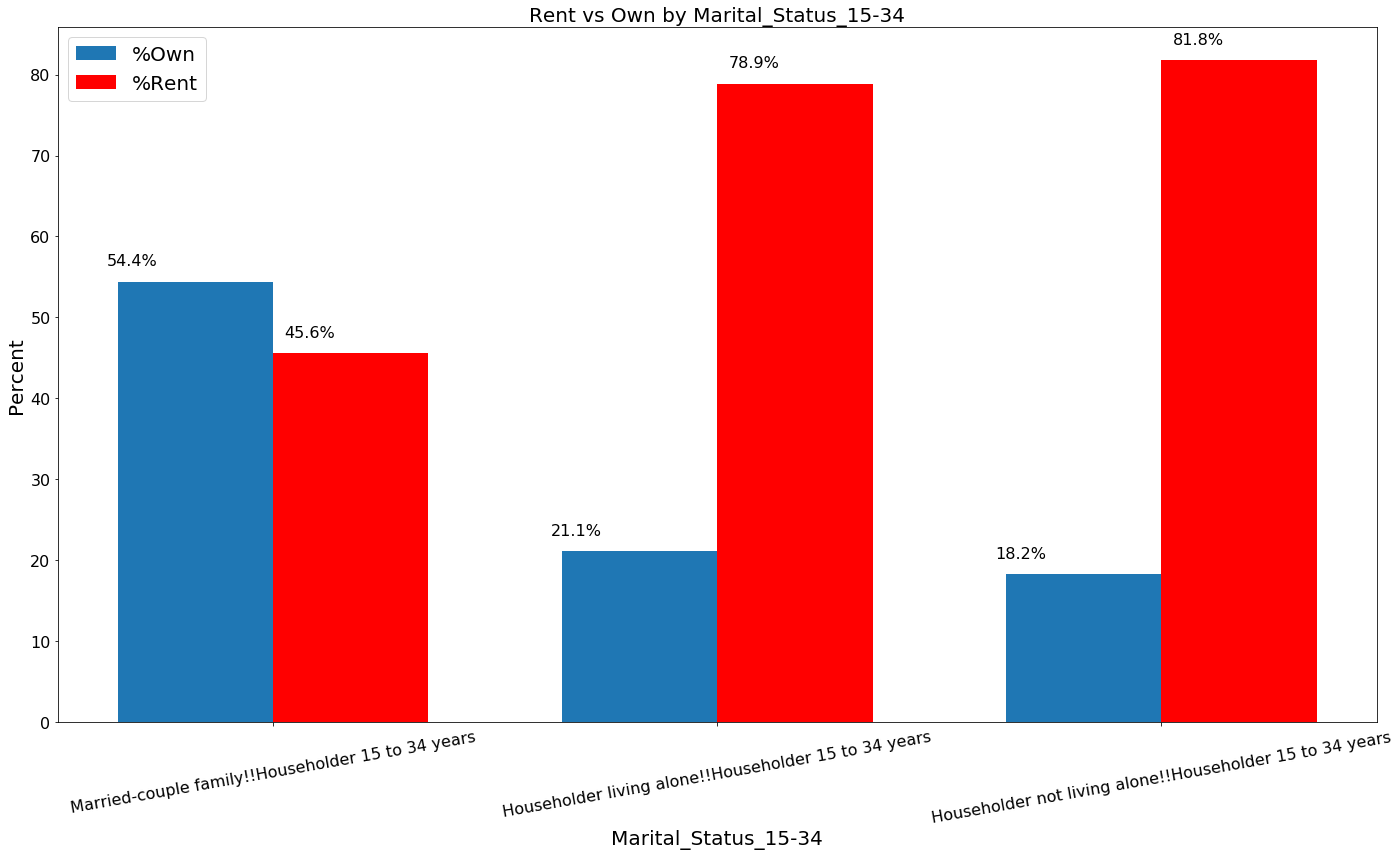

In [340]:
get_chart(young_df, 'Marital_Status_15-34', 10)

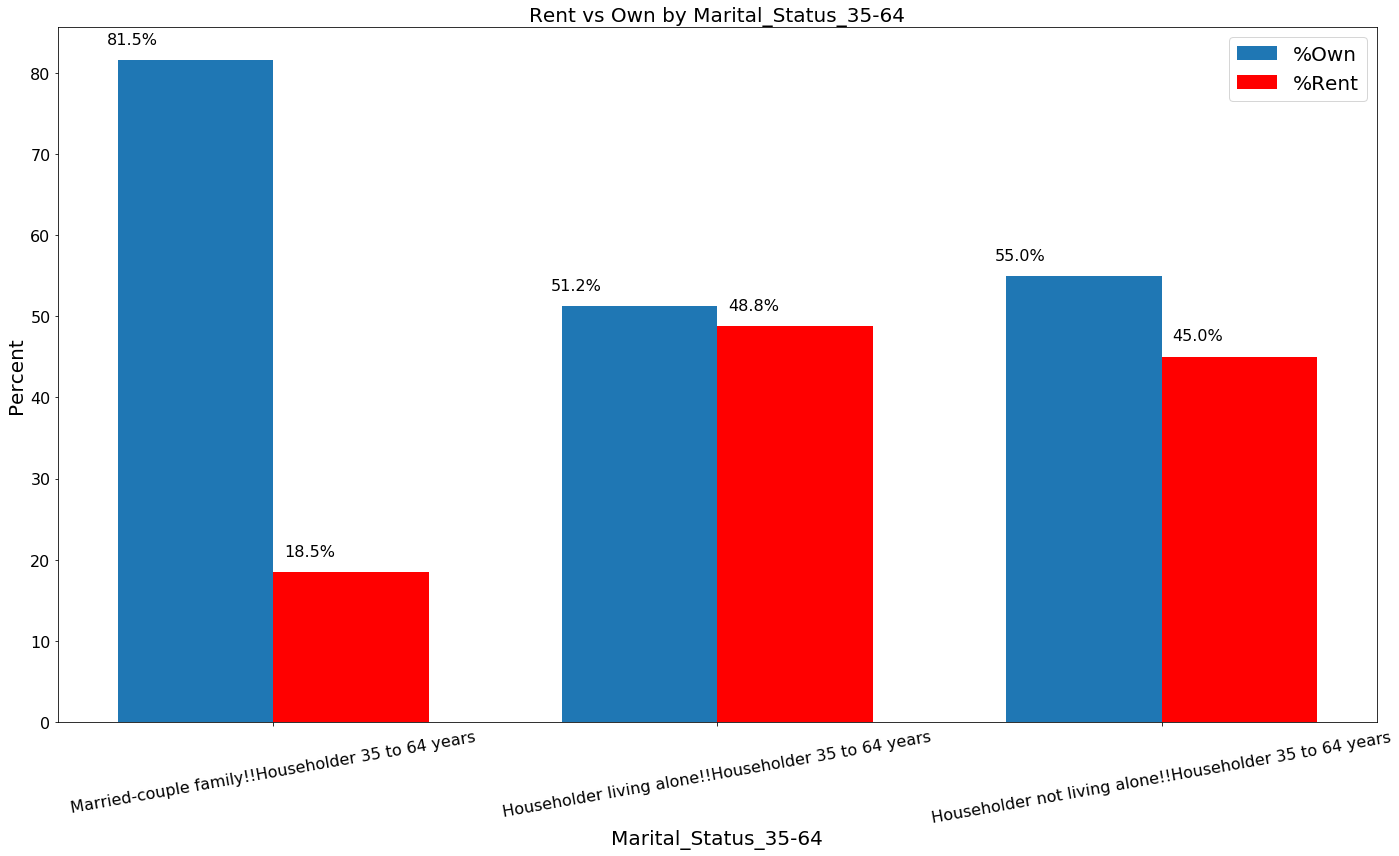

In [341]:
get_chart(mid_df, 'Marital_Status_35-64', 10)

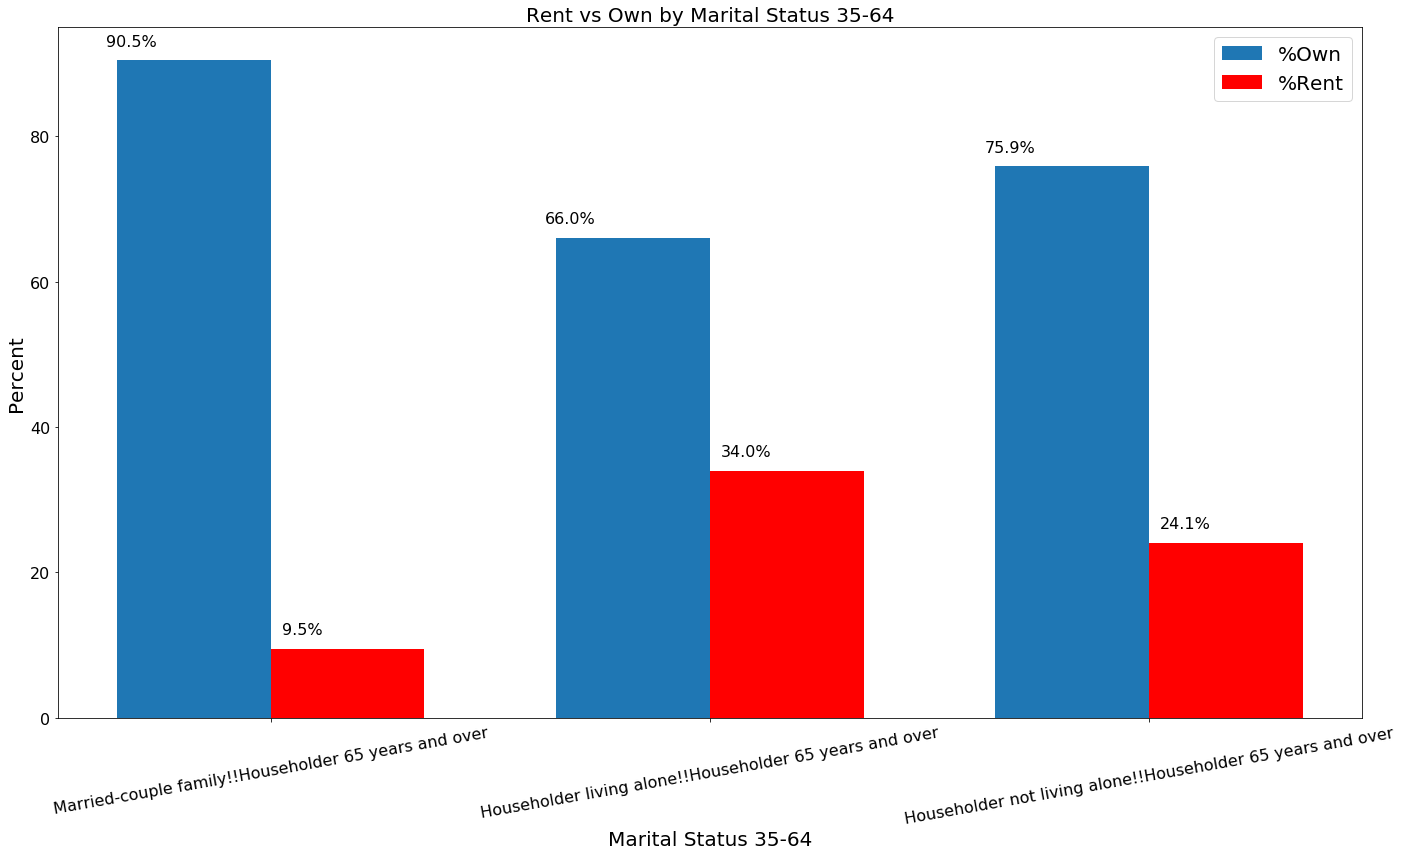

In [80]:
get_chart(senior_df,'Marital Status 35-64', 10)

In [26]:
small_type_df = type_df.iloc[[1,19],:]
small_type_df

,Category,Own,Rent,Total,%Own,%Rent
1,Family households!!Married-couple family,46051807,11765141,57816948,79.651051,20.348949
19,Nonfamily households!!Householder not living a...,3034713,4786056,7820769,38.803256,61.196744


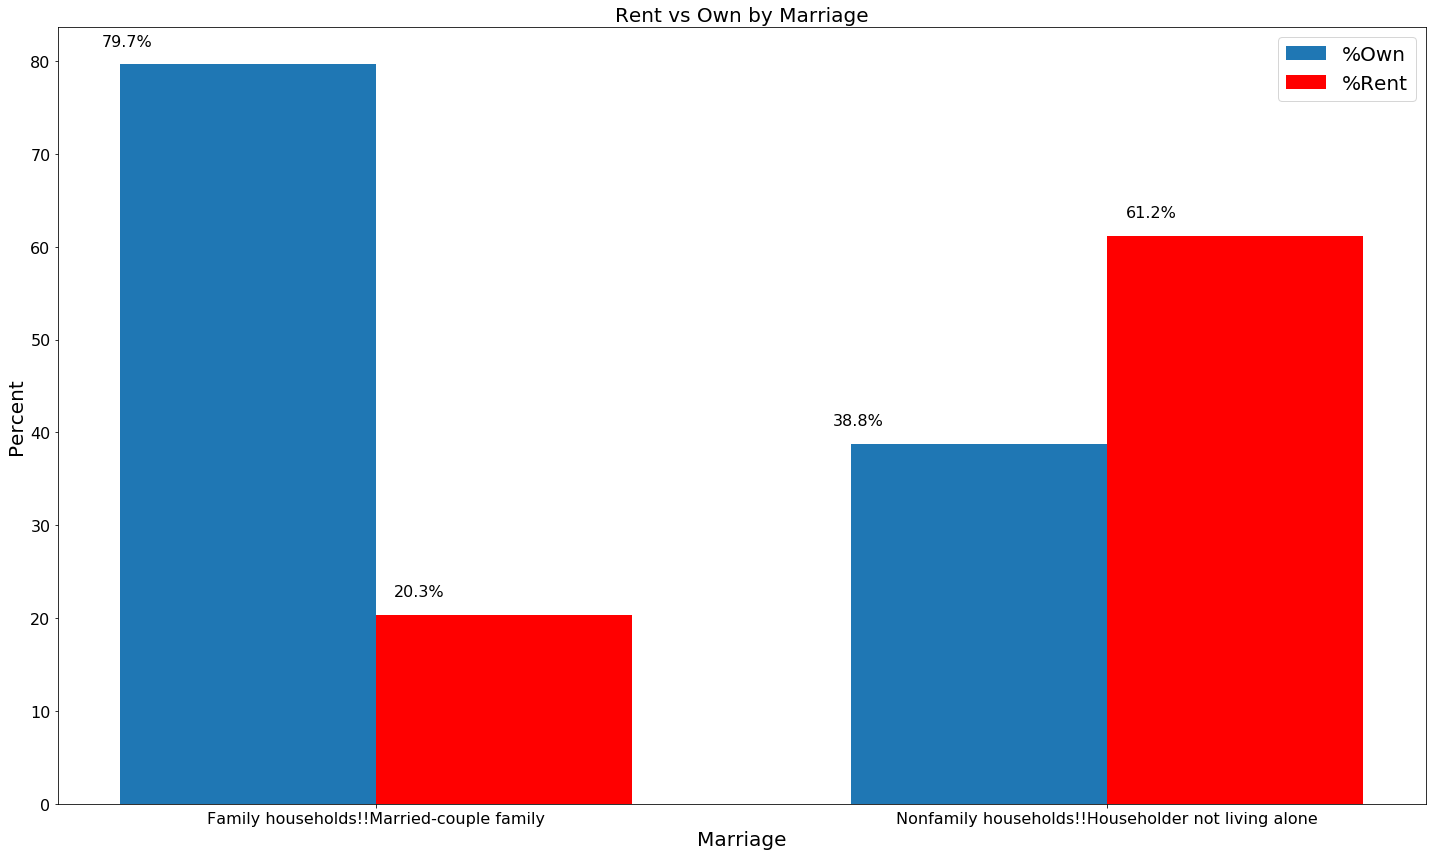

In [27]:
get_chart(small_type_df, 'Marriage', 0)

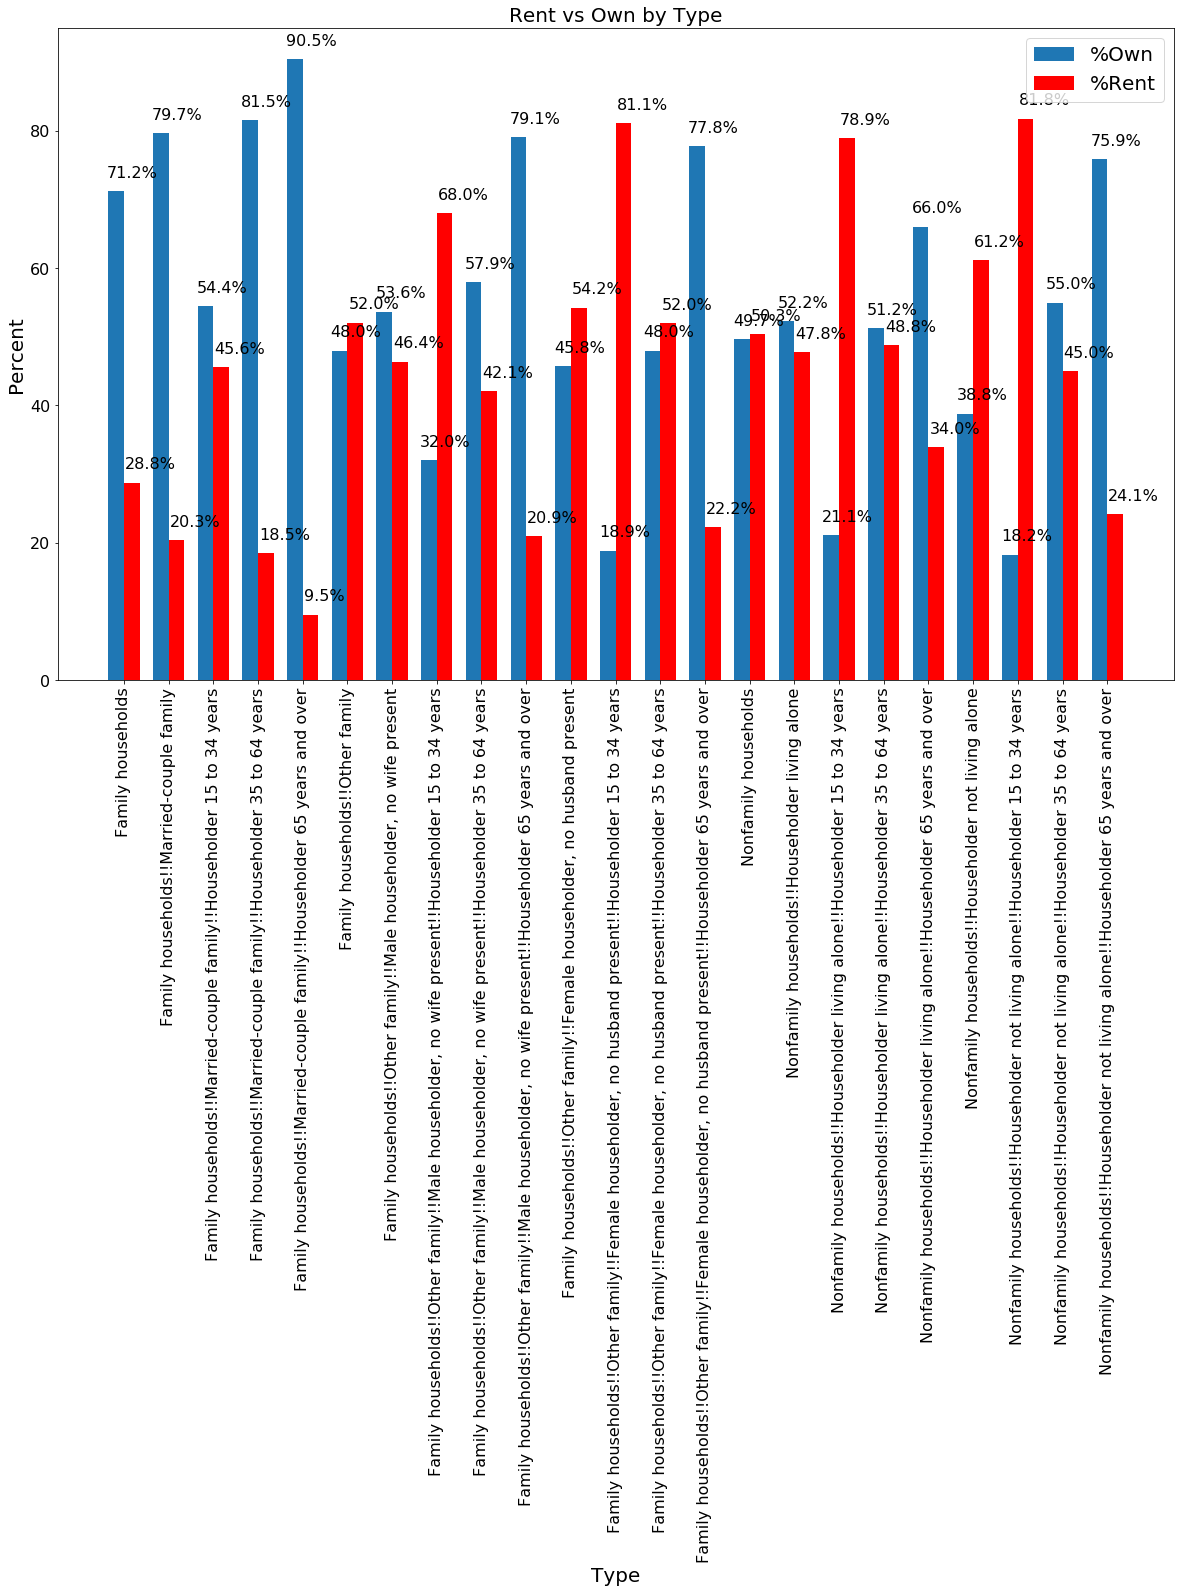

In [28]:
get_chart(type_df, 'Type', 90)

In [29]:
#household by children
feature_gen(17,'B25012_')

https://api.census.gov/data/2018/acs/acs5?get=NAME,B25012_001E,B25012_002E,B25012_003E,B25012_004E,B25012_005E,B25012_006E,B25012_007E,B25012_008E,B25012_009E,B25012_010E,B25012_011E,B25012_012E,B25012_013E,B25012_014E,B25012_015E,B25012_016E,B25012_017E&for=us:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>


,Category,Own,Rent,Total,%Own,%Rent
0,With related children of the householder under 18,22905266,14165516,37070782,61.787922,38.212078
1,With related children of the householder under...,20424472,13010627,33435099,61.086919,38.913081
2,With related children of the householder under...,3867625,3376866,7244491,53.387119,46.612881
3,With related children of the householder under...,3655962,3014691,6670653,54.806658,45.193342
4,With related children of the householder under...,12900885,6619070,19519955,66.090752,33.909248


In [30]:
child_df = census_df

In [31]:
#save as csv
child_df.to_csv("data/child.csv")

In [34]:
child_df
small_child_df = child_df.iloc[[0,2,3,4,6],:]
small_child_df['Category'][0] = 'With Children Under 18'
small_child_df['Category'][2] = 'With Children Under 6'
small_child_df['Category'][3] = 'With Children Under 6 and 6-17'
small_child_df['Category'][4] = 'With Children Age 6-17'
small_child_df['Category'][6] = 'With No Children'

In [35]:
small_child_df

,Category,Own,Rent,Total,%Own,%Rent
0,With Children Under 18,22905266,14165516,37070782,61.787922,38.212078
2,With Children Under 6,3867625,3376866,7244491,53.387119,46.612881
3,With Children Under 6 and 6-17,3655962,3014691,6670653,54.806658,45.193342
4,With Children Age 6-17,12900885,6619070,19519955,66.090752,33.909248
6,With No Children,53539544,29119802,82659346,64.771313,35.228687


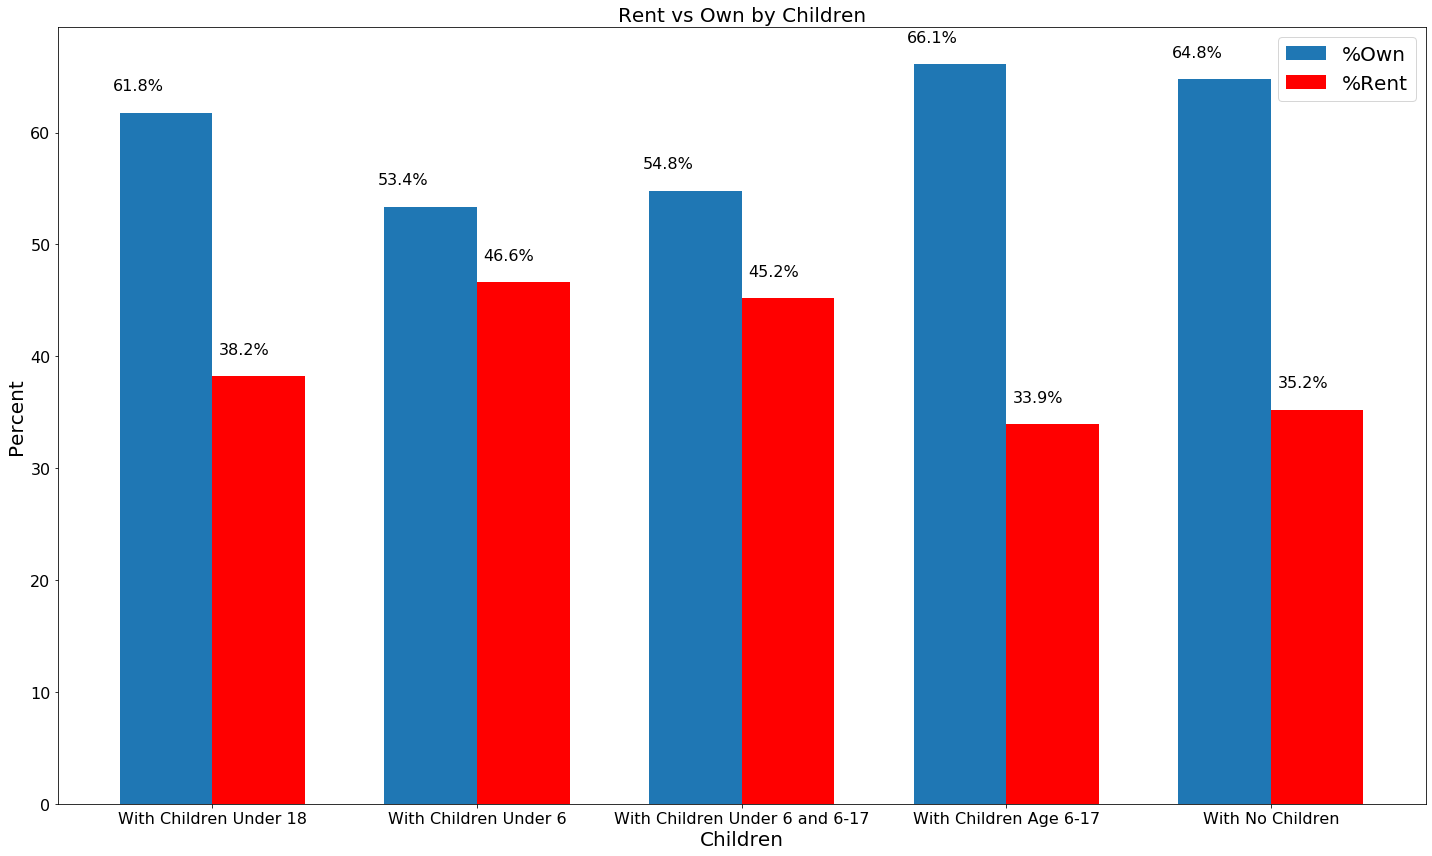

In [36]:
get_chart(small_child_df, 'Children', 0)

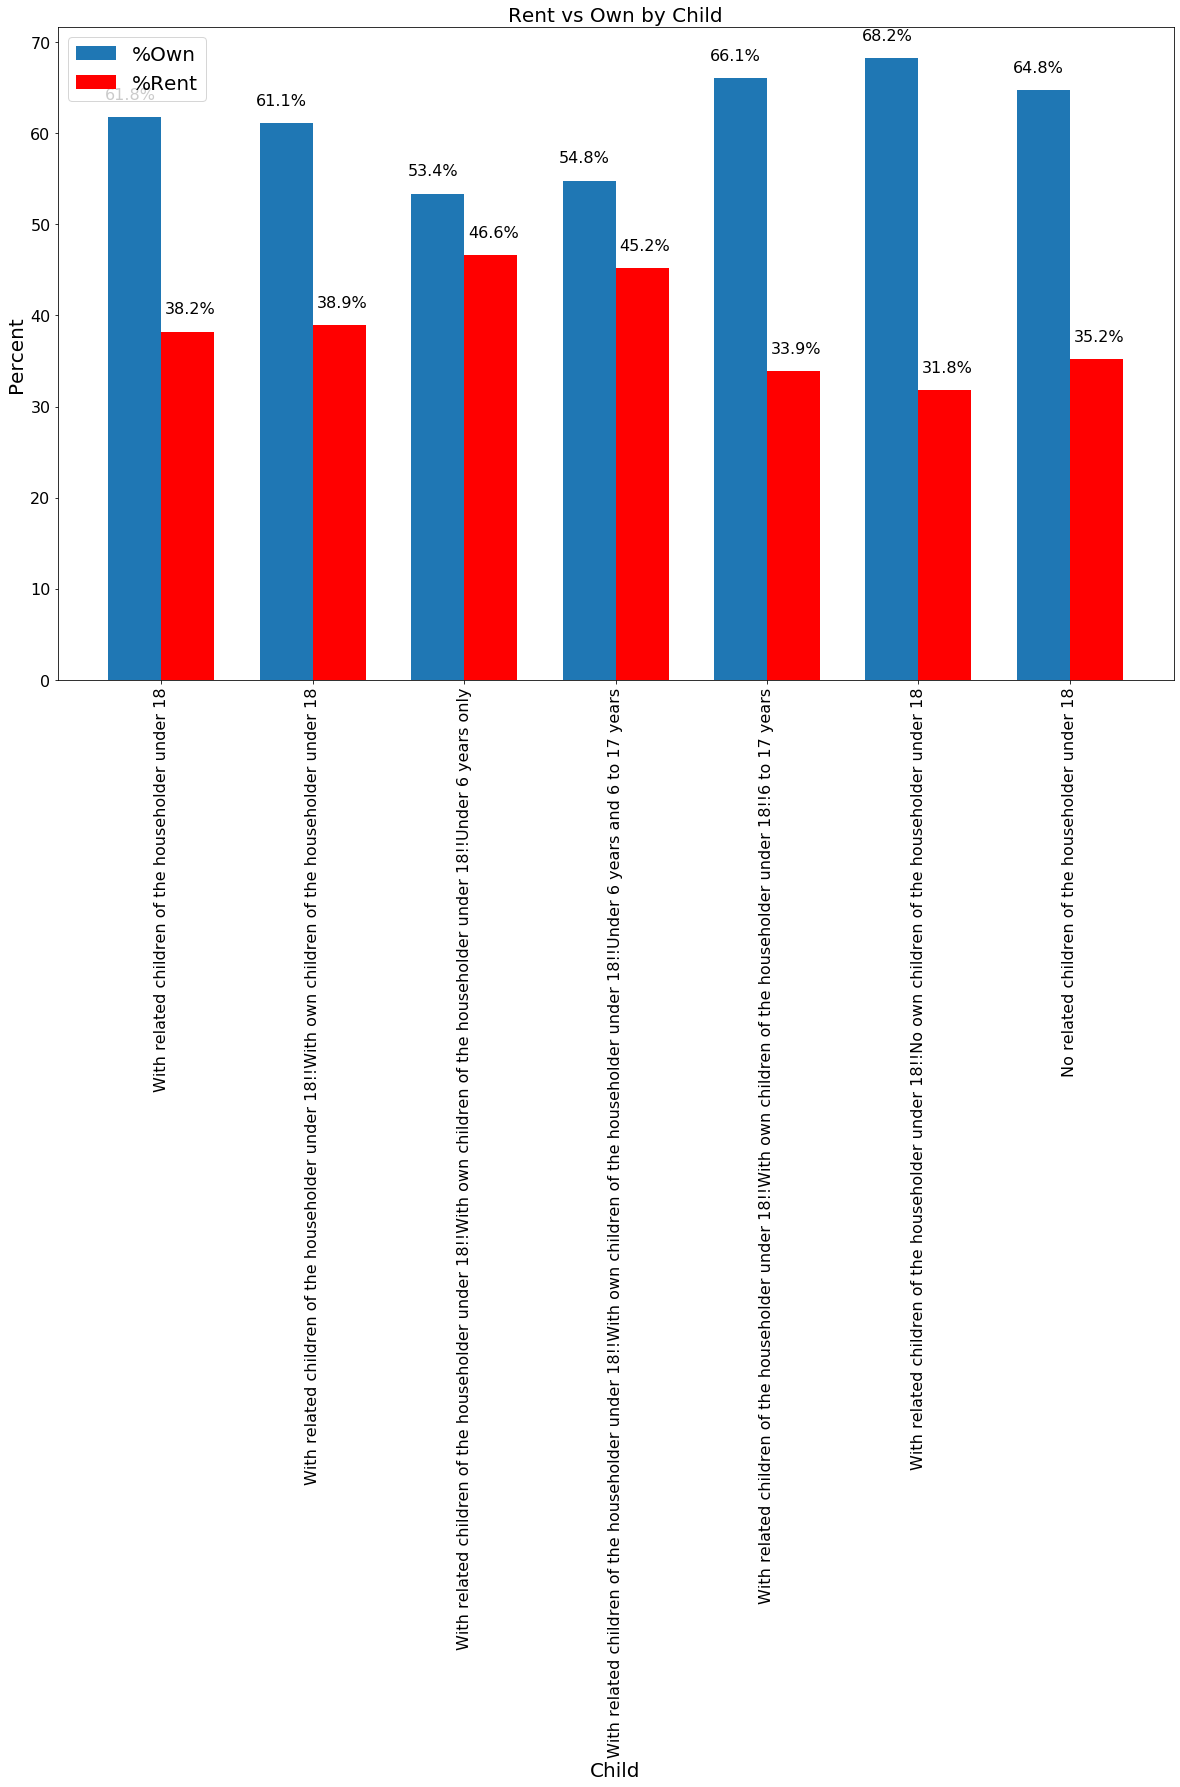

In [38]:
get_chart(child_df, 'Child', 90)

In [39]:
#household by education
feature_gen(11,'B25013_')

https://api.census.gov/data/2018/acs/acs5?get=NAME,B25013_001E,B25013_002E,B25013_003E,B25013_004E,B25013_005E,B25013_006E,B25013_007E,B25013_008E,B25013_009E,B25013_010E,B25013_011E&for=us:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>


,Category,Own,Rent,Total,%Own,%Rent
0,Less than high school graduate,6125523,6417332,12542855,48.836752,51.163248
1,High school graduate (including equivalency),18017123,11417261,29434384,61.211143,38.788857
2,Some college or associate's degree,22958513,14080823,37039336,61.984138,38.015862
3,Bachelor's degree or higher,29343651,11369902,40713553,72.073422,27.926578


In [40]:
educate_df = census_df

In [41]:
#save as csv
educate_df.to_csv("data/educate.csv")

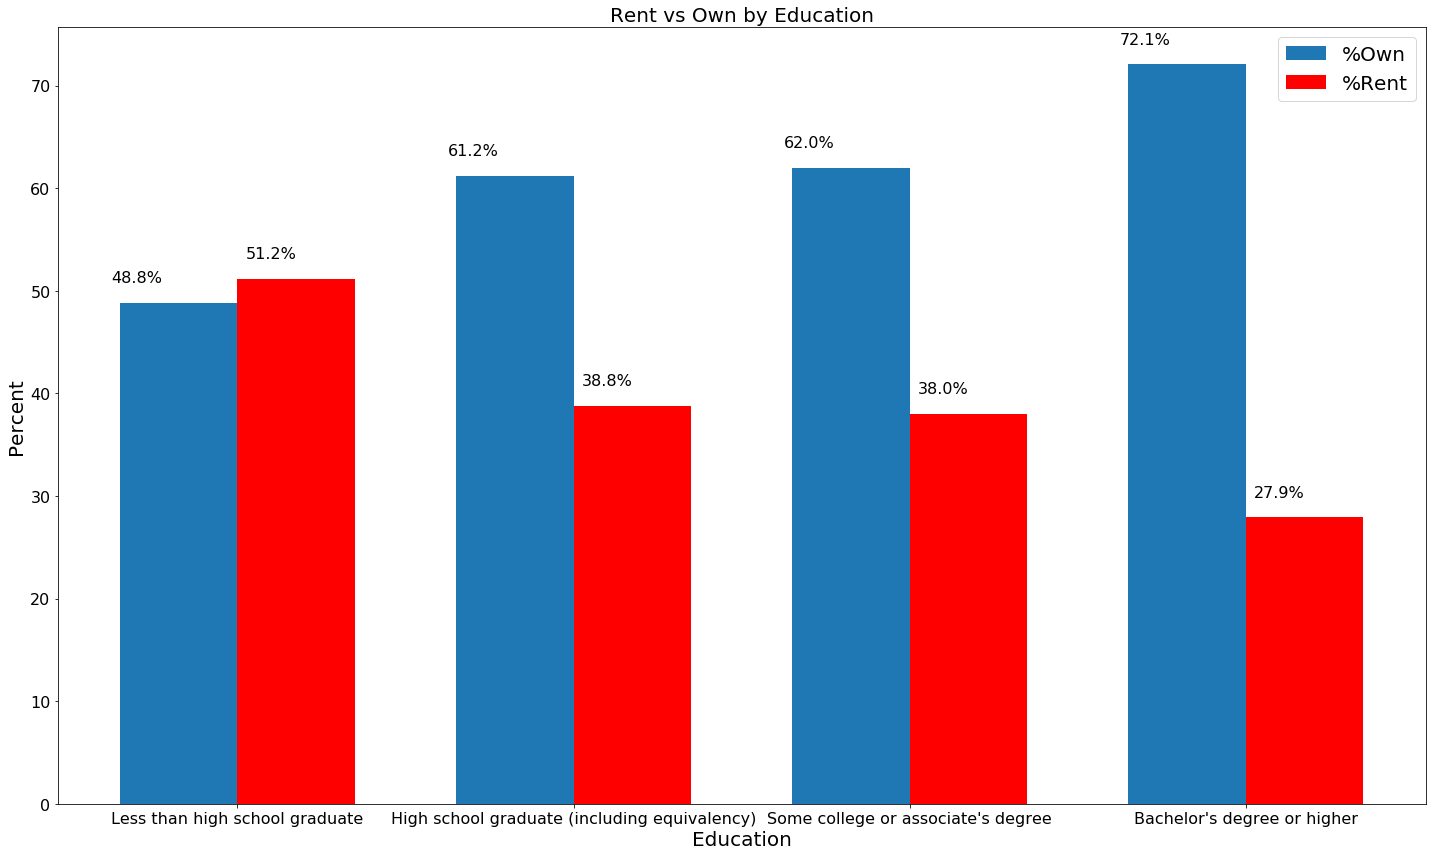

In [42]:
get_chart(educate_df, 'Education', 0)

In [43]:
#household by type & children
feature_gen(27,'B25115_')

https://api.census.gov/data/2018/acs/acs5?get=NAME,B25115_001E,B25115_002E,B25115_003E,B25115_004E,B25115_005E,B25115_006E,B25115_007E,B25115_008E,B25115_009E,B25115_010E,B25115_011E,B25115_012E,B25115_013E,B25115_014E,B25115_015E,B25115_016E,B25115_017E,B25115_018E,B25115_019E,B25115_020E,B25115_021E,B25115_022E,B25115_023E,B25115_024E,B25115_025E,B25115_026E,B25115_027E&for=us:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>


,Category,Own,Rent,Total,%Own,%Rent
0,Family households,56066627,22630476,78697103,71.243572,28.756428
1,Family households!!Married-couple family,46051807,11765141,57816948,79.651051,20.348949
2,Family households!!Married-couple family!!With...,16636528,6103898,22740426,73.158383,26.841617
3,Family households!!Married-couple family!!No o...,29415279,5661243,35076522,83.860307,16.139693
4,Family households!!Other family,10014820,10865335,20880155,47.963341,52.036659


In [44]:
child_type_df = census_df

In [45]:
#save as csv
child_type_df.to_csv("data/child_type.csv")

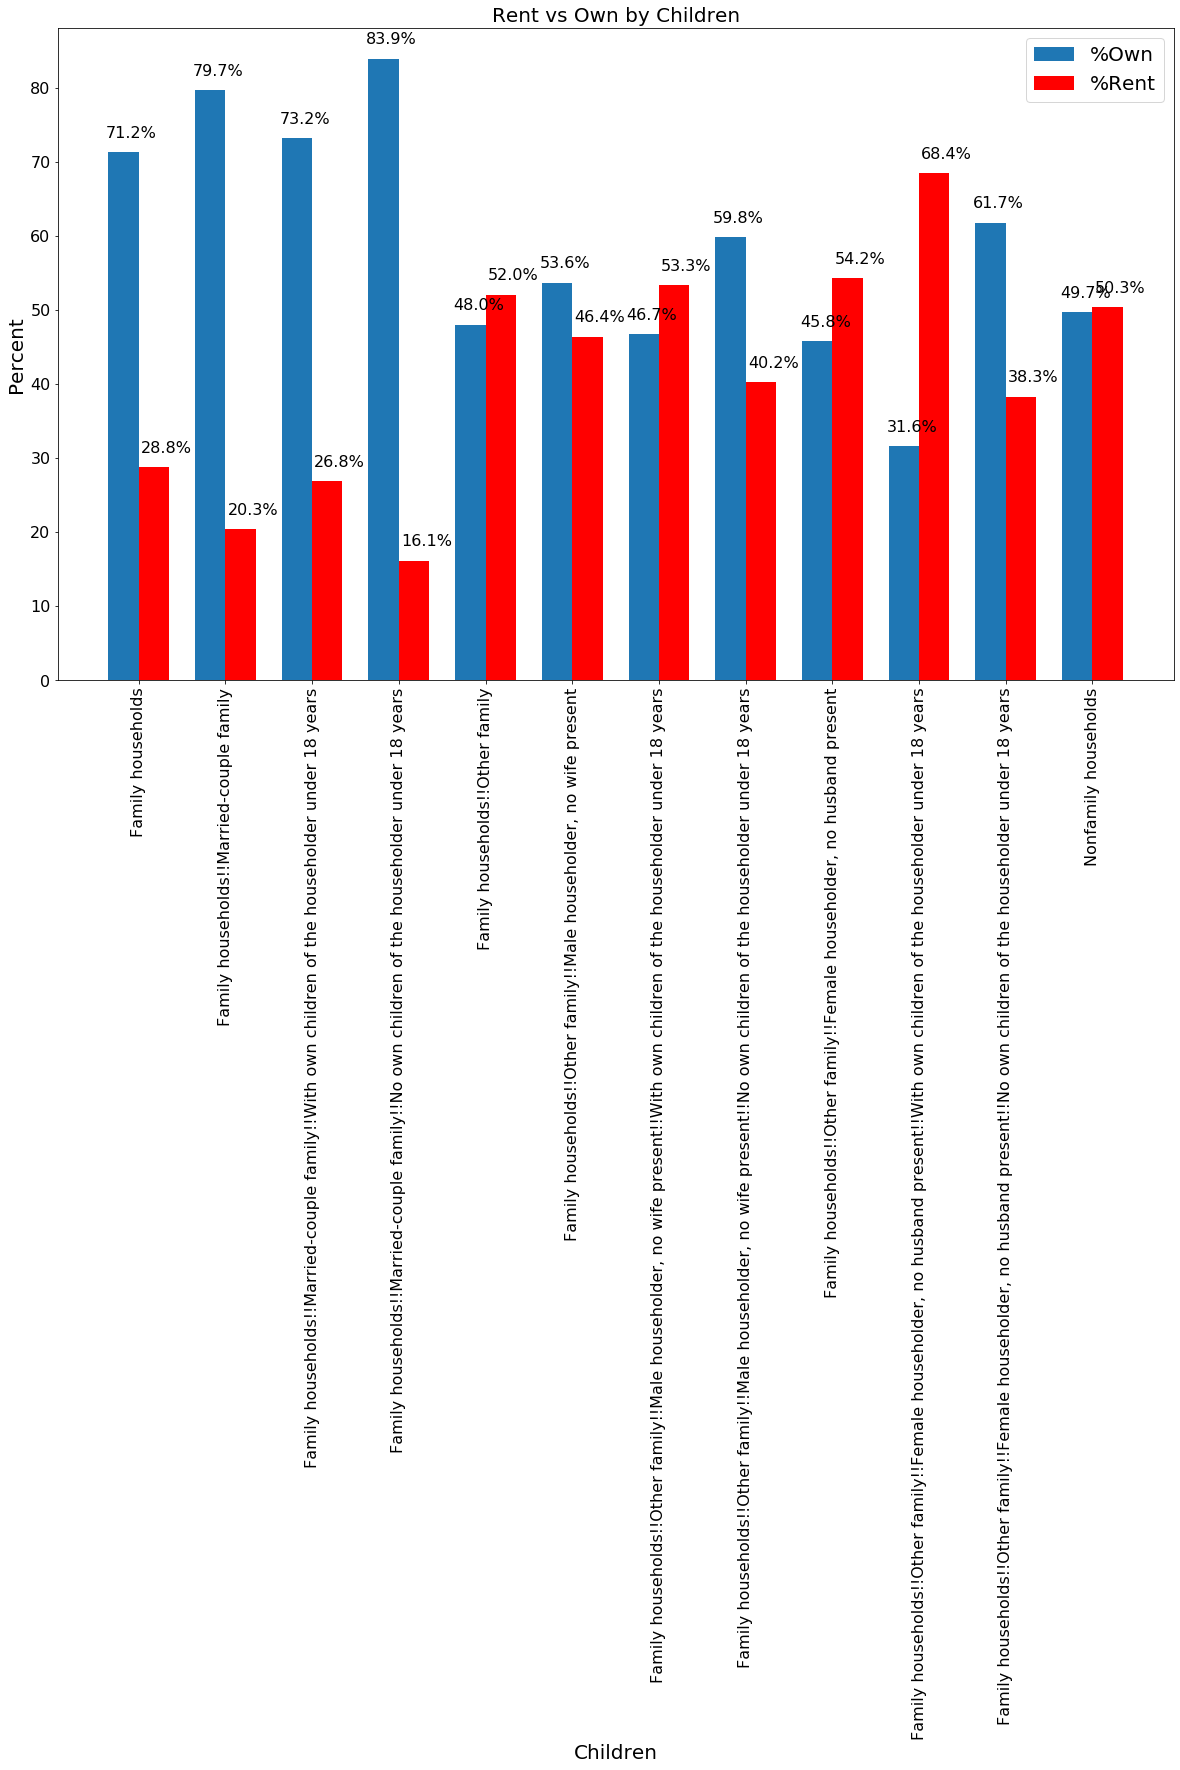

In [46]:
get_chart(child_type_df, 'Children', 90)

In [47]:
feature_gen(25,'B25118_')

https://api.census.gov/data/2018/acs/acs5?get=NAME,B25118_001E,B25118_002E,B25118_003E,B25118_004E,B25118_005E,B25118_006E,B25118_007E,B25118_008E,B25118_009E,B25118_010E,B25118_011E,B25118_012E,B25118_013E,B25118_014E,B25118_015E,B25118_016E,B25118_017E,B25118_018E,B25118_019E,B25118_020E,B25118_021E,B25118_022E,B25118_023E,B25118_024E,B25118_025E&for=us:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>


,Category,Own,Rent,Total,%Own,%Rent
0,"Less than $5,000",1413840,2461303,3875143,36.484847,63.515153
1,"$5,000 to $9,999",1164050,2545112,3709162,31.383099,68.616901
2,"$10,000 to $14,999",2091274,3415777,5507051,37.974480,62.025520
3,"$15,000 to $19,999",2411482,3076807,5488289,43.938685,56.061315
4,"$20,000 to $24,999",2673570,2985102,5658672,47.247305,52.752695


In [48]:
income_df = census_df

In [49]:
#save as csv
income_df.to_csv("data/income.csv")

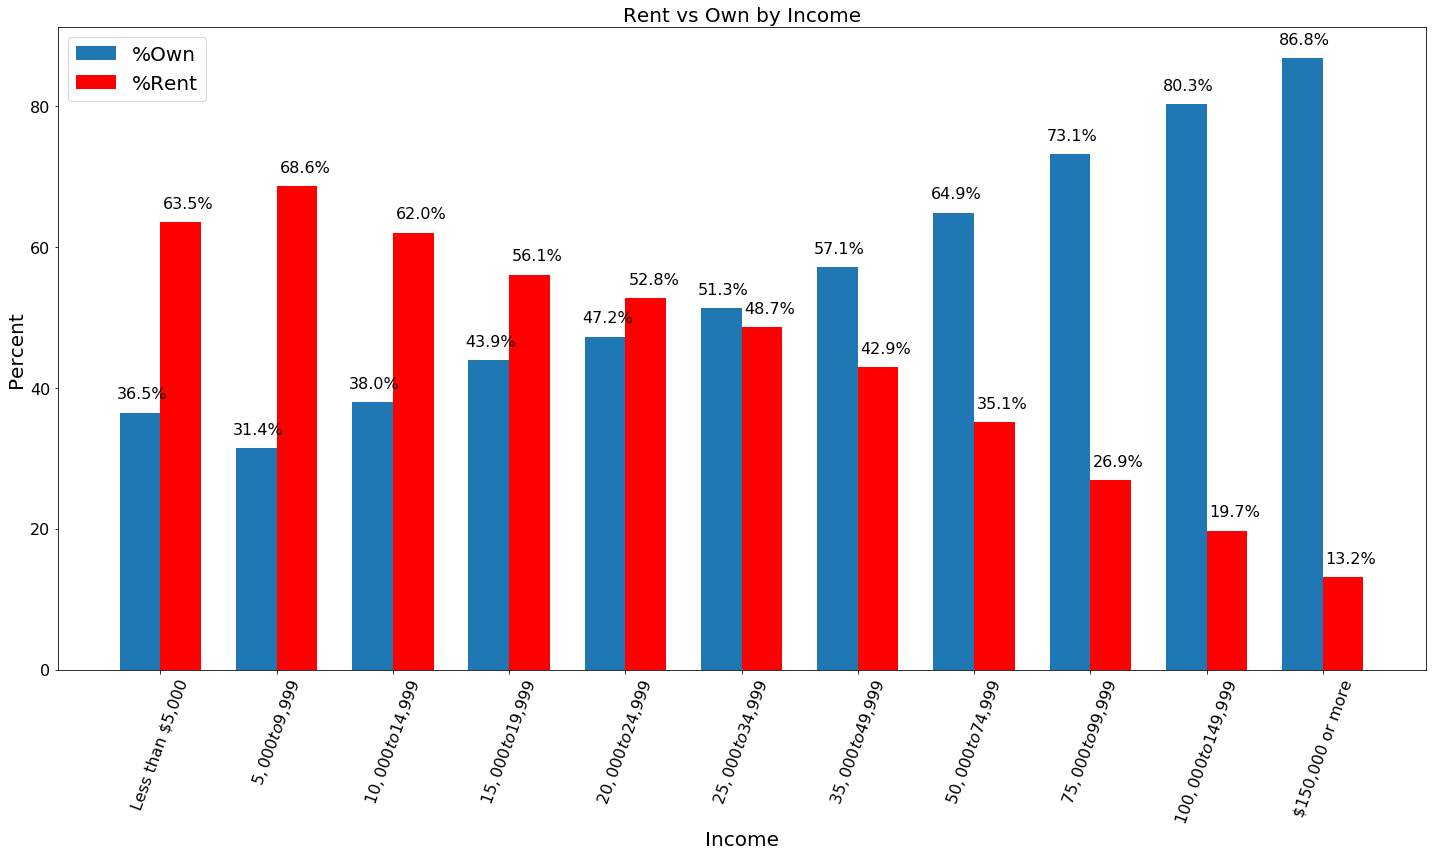

In [50]:
get_chart(income_df, 'Income', 70)

In [51]:
feature_gen(45,'B25128_')

https://api.census.gov/data/2018/acs/acs5?get=NAME,B25128_001E,B25128_002E,B25128_003E,B25128_004E,B25128_005E,B25128_006E,B25128_007E,B25128_008E,B25128_009E,B25128_010E,B25128_011E,B25128_012E,B25128_013E,B25128_014E,B25128_015E,B25128_016E,B25128_017E,B25128_018E,B25128_019E,B25128_020E,B25128_021E,B25128_022E,B25128_023E,B25128_024E,B25128_025E,B25128_026E,B25128_027E,B25128_028E,B25128_029E,B25128_030E,B25128_031E,B25128_032E,B25128_033E,B25128_034E,B25128_035E,B25128_036E,B25128_037E,B25128_038E,B25128_039E,B25128_040E,B25128_041E,B25128_042E,B25128_043E,B25128_044E,B25128_045E&for=us:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>


,Category,Own,Rent,Total,%Own,%Rent
0,15 to 34 years,7554156,15170987,22725143,33.241401,66.758599
1,15 to 34 years!!Moved in 2017 or later,589775,2153614,2743389,21.498045,78.501955
2,15 to 34 years!!Moved in 2015 to 2016,1589591,4687481,6277072,25.323766,74.676234
3,15 to 34 years!!Moved in 2010 to 2014,3633167,7302554,10935721,33.222931,66.777069
4,15 to 34 years!!Moved in 2000 to 2009,1531867,880030,2411897,63.512953,36.487047


In [52]:
tenure_year_df = census_df

In [89]:
young_ten_df = tenure_year_df.iloc[0:6]
mid_ten_df = tenure_year_df.iloc[7:13].reset_index(drop=True)
senior_ten_df = tenure_year_df.iloc[14:20].reset_index(drop=True)

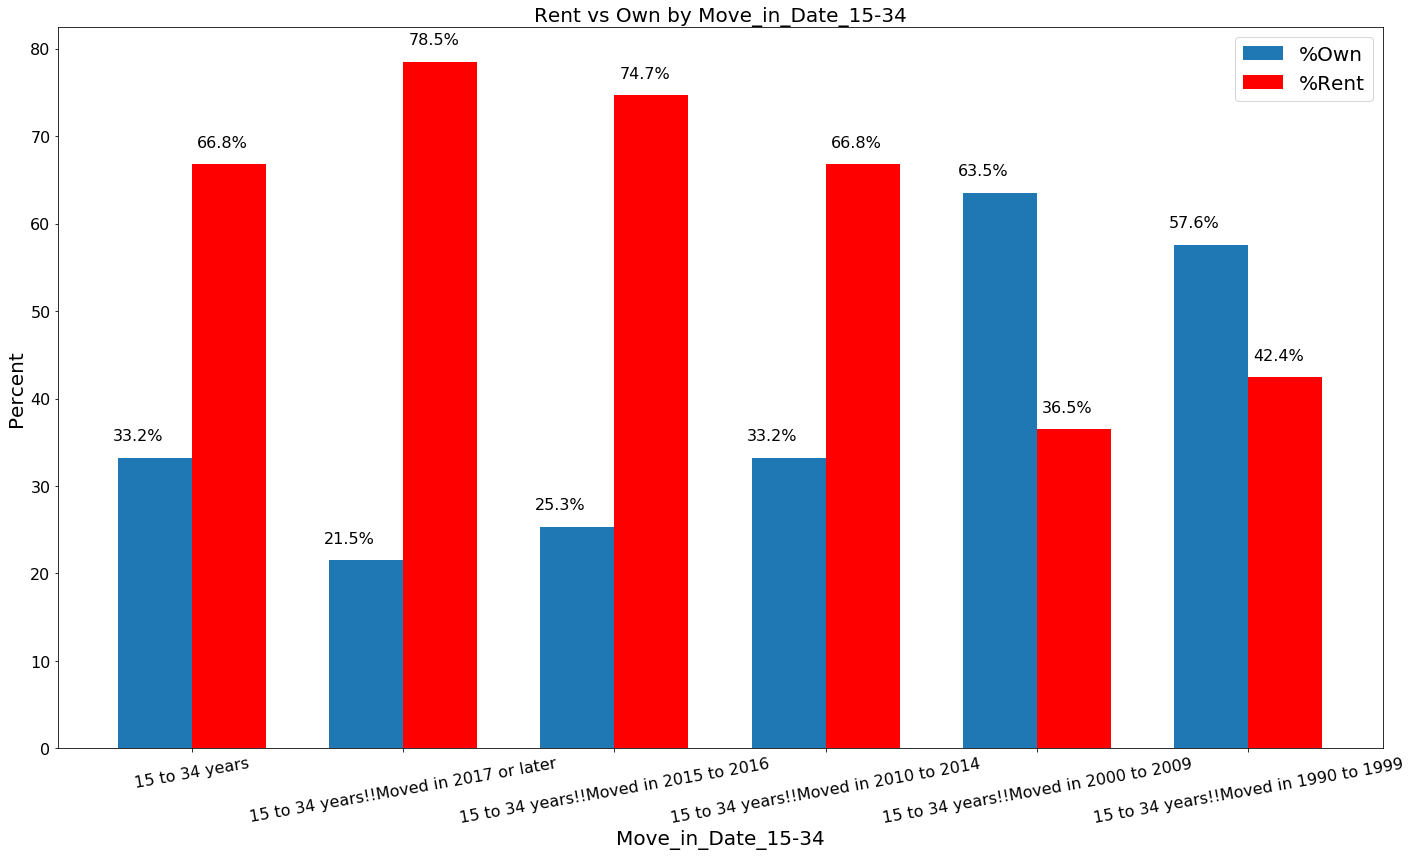

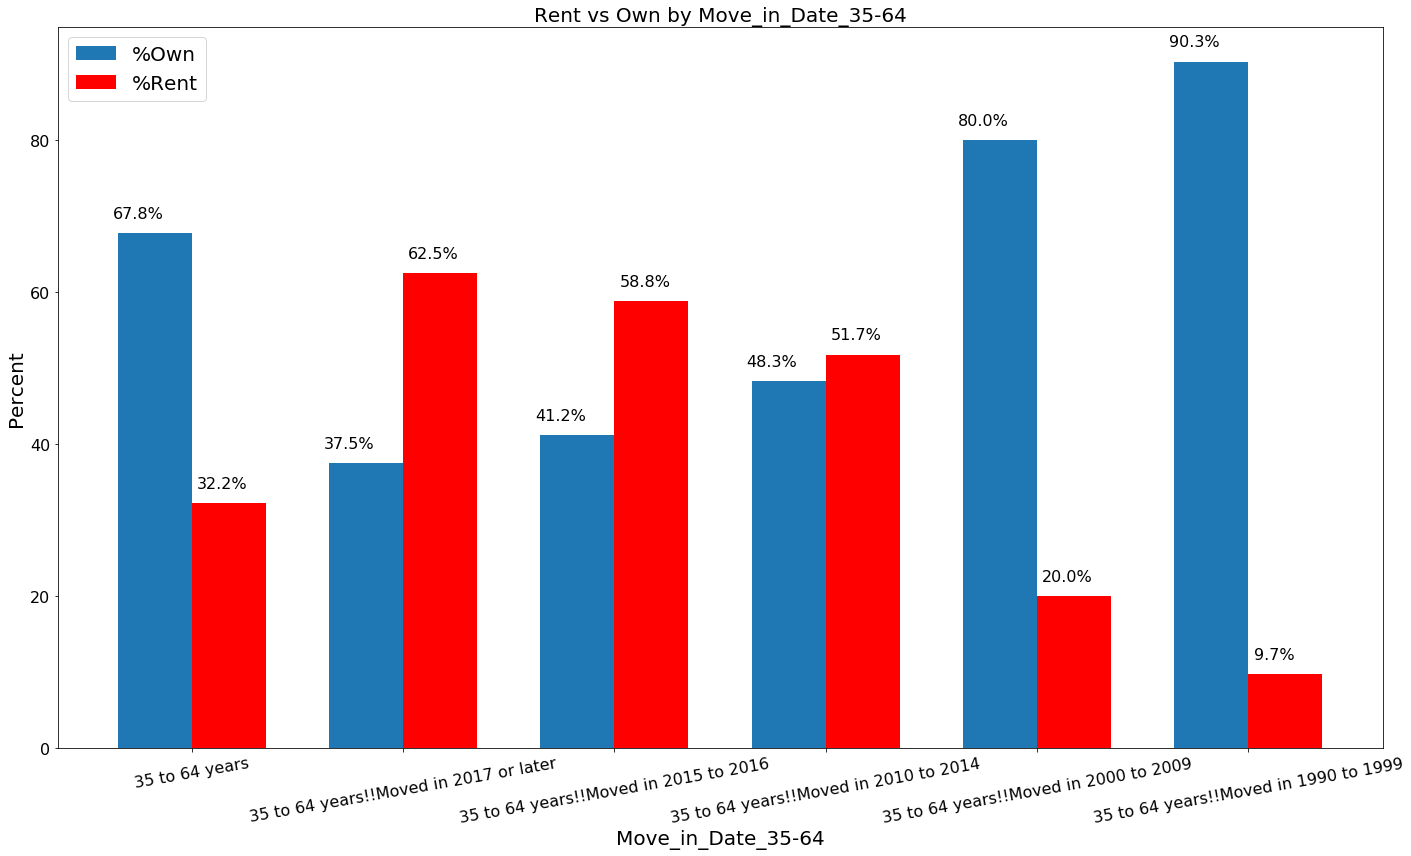

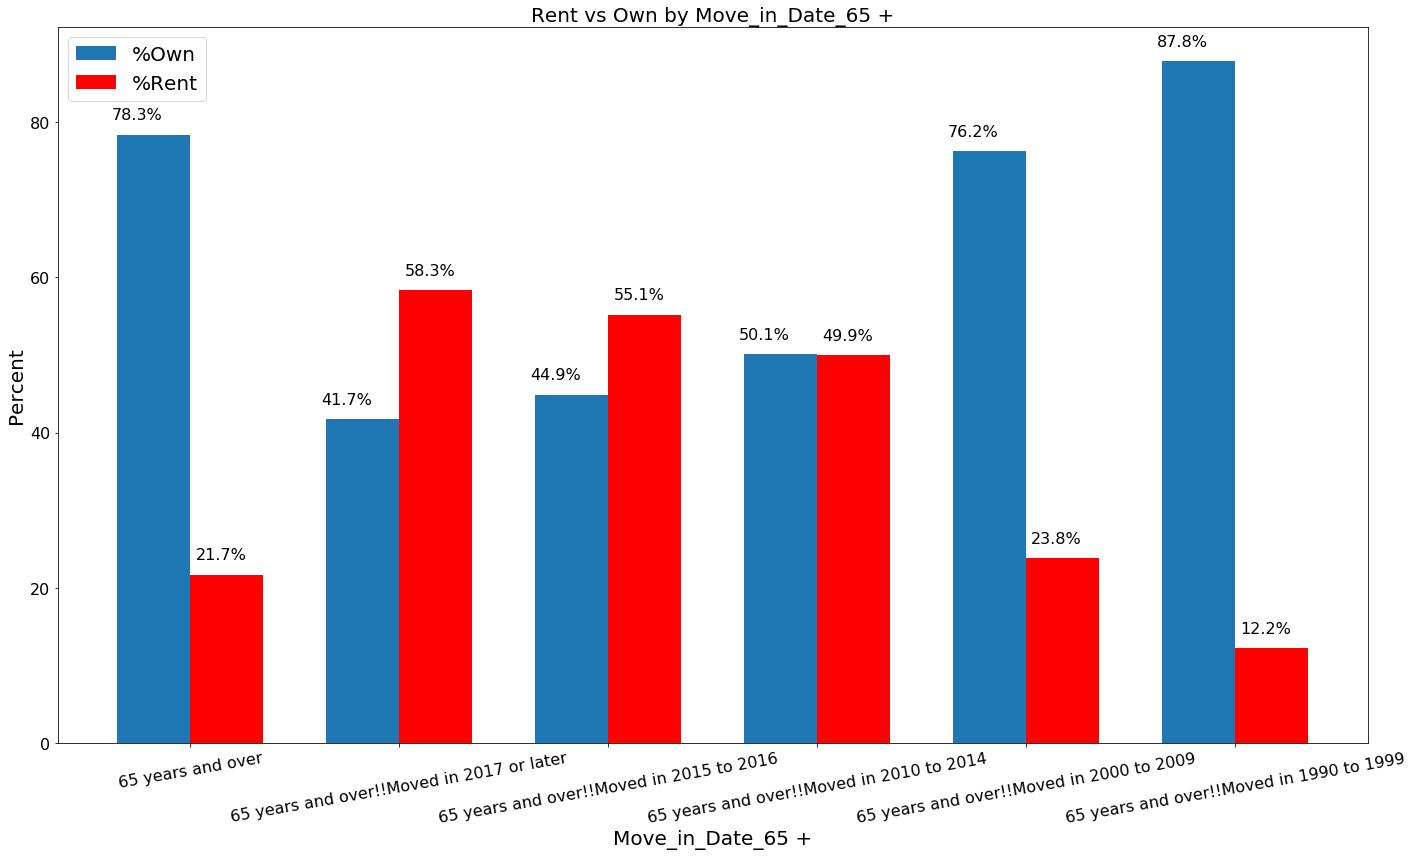

In [342]:
get_chart(young_ten_df,'Move_in_Date_15-34',10)
get_chart(mid_ten_df,'Move_in_Date_35-64',10)
get_chart(senior_ten_df,'Move_in_Date_65 +', 10)

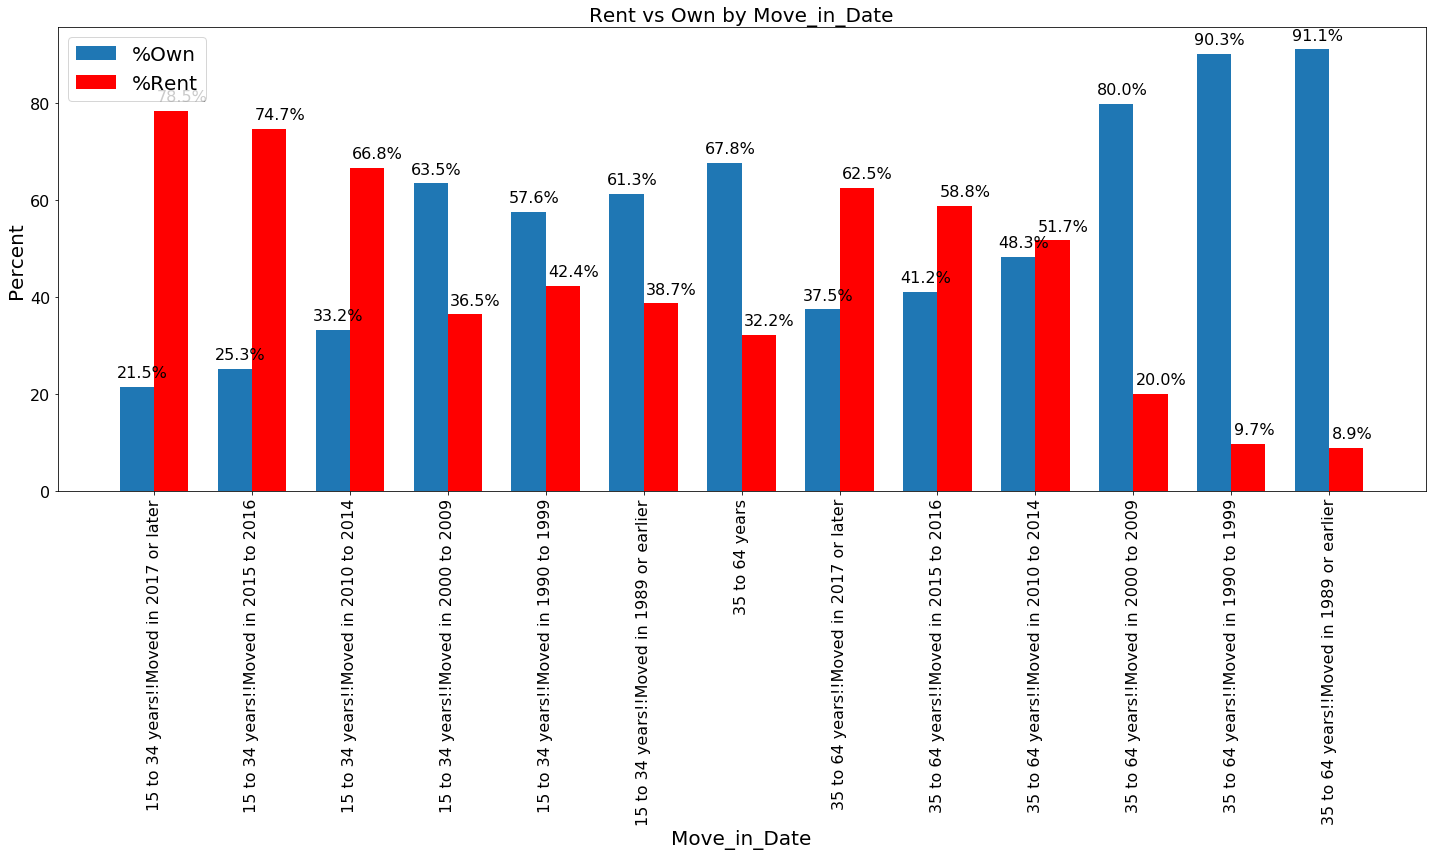

In [53]:
small_ten_df = tenure_year_df.iloc[1:14,:]
get_chart(small_ten_df,'Move_in_Date',90)

In [54]:
tenure_year_df.to_csv("data/tenure_year_df.csv")

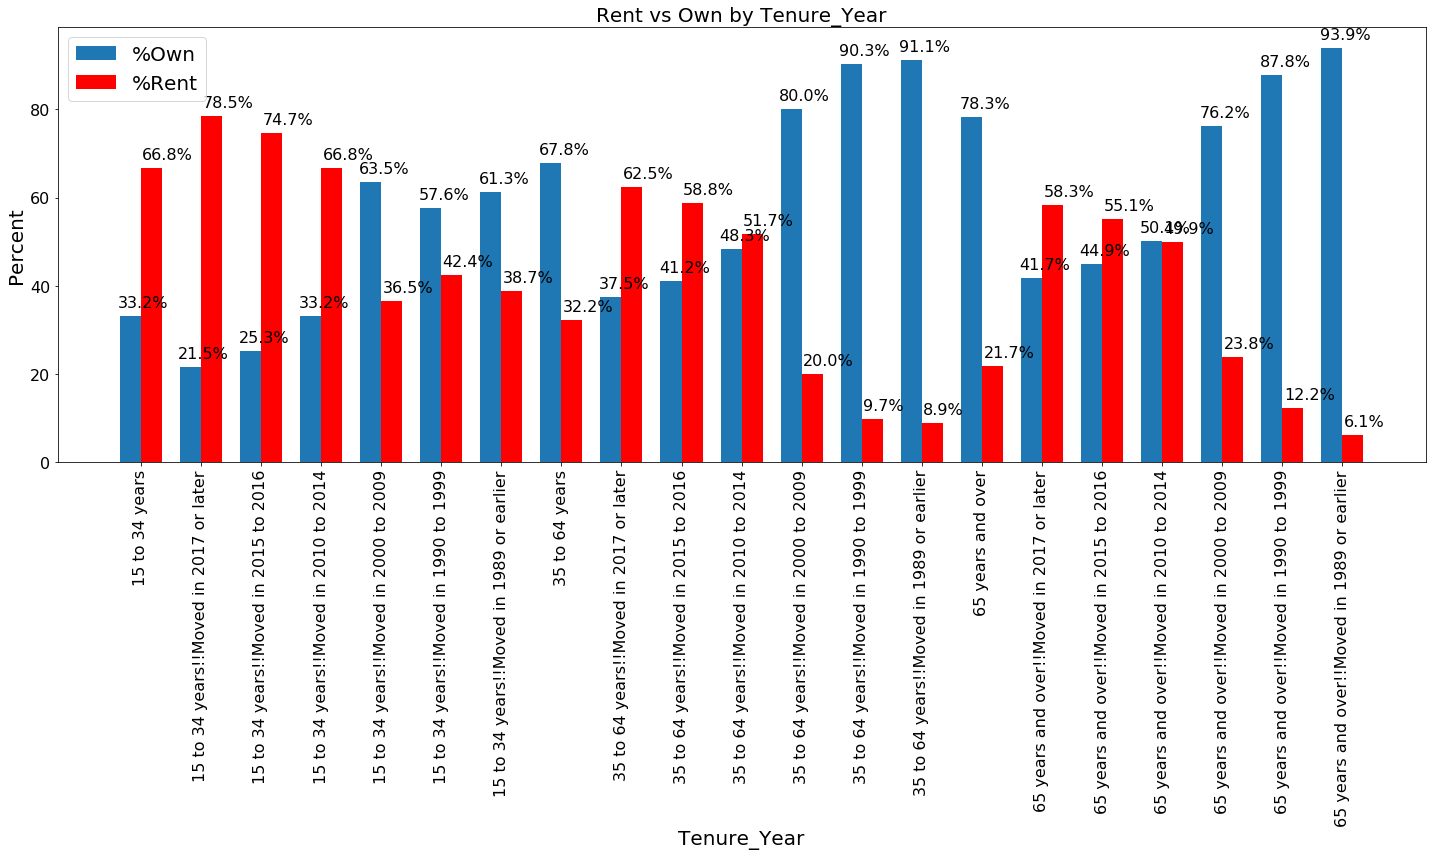

In [55]:
get_chart(tenure_year_df, 'Tenure_Year', 90)

In [307]:
zip_gen(21,'B25007_')

https://api.census.gov/data/2018/acs/acs5?get=NAME,B25007_001E,B25007_002E,B25007_003E,B25007_004E,B25007_005E,B25007_006E,B25007_007E,B25007_008E,B25007_009E,B25007_010E,B25007_011E,B25007_012E,B25007_013E,B25007_014E,B25007_015E,B25007_016E,B25007_017E,B25007_018E,B25007_019E,B25007_020E,B25007_021E&for=zip%20code%20tabulation%20area:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>
error in object conversion


,NAME,Estimate!!Total,Estimate!!Total!!Owner occupied,Estimate!!Total!!Owner occupied!!Householder 15 to 24 years,Estimate!!Total!!Owner occupied!!Householder 25 to 34 years,Estimate!!Total!!Owner occupied!!Householder 35 to 44 years,Estimate!!Total!!Owner occupied!!Householder 45 to 54 years,Estimate!!Total!!Owner occupied!!Householder 55 to 59 years,Estimate!!Total!!Owner occupied!!Householder 60 to 64 years,Estimate!!Total!!Owner occupied!!Householder 65 to 74 years,Estimate!!Total!!Owner occupied!!Householder 75 to 84 years,Estimate!!Total!!Owner occupied!!Householder 85 years and over,Estimate!!Total!!Renter occupied,Estimate!!Total!!Renter occupied!!Householder 15 to 24 years,Estimate!!Total!!Renter occupied!!Householder 25 to 34 years,Estimate!!Total!!Renter occupied!!Householder 35 to 44 years,Estimate!!Total!!Renter occupied!!Householder 45 to 54 years,Estimate!!Total!!Renter occupied!!Householder 55 to 59 years,Estimate!!Total!!Renter occupied!!Householder 60 to 64 years,Estimate!!Total!!Renter occupied!!Householder 65 to 74 years,Estimate!!Total!!Renter occupied!!Householder 75 to 84 years,Estimate!!Total!!Renter occupied!!Householder 85 years and over,zip code tabulation area
0,ZCTA5 85395,9999,7841,10,465,1231,1193,618,750,2341,1076,157,2158,325,339,556,421,150,73,129,70,95,85395
1,ZCTA5 67502,9997,7450,41,608,995,1317,730,1032,1411,945,371,2547,370,461,306,282,140,147,244,312,285,67502
2,ZCTA5 22408,9997,7402,16,813,1601,1662,940,756,988,517,109,2595,155,841,744,489,158,104,81,15,8,22408
3,ZCTA5 78728,9997,2665,41,476,492,713,266,273,339,65,0,7332,436,2354,1856,1240,338,230,587,126,165,78728
4,ZCTA5 15101,9996,7927,23,663,1369,1675,818,874,1451,753,301,2069,234,444,182,150,85,48,237,314,375,15101


In [308]:
col_list = zip_df.columns.values[1:]

for col in col_list:
    zip_df[col] = zip_df[col].astype(int)

In [309]:
zip_age = zip_df

len(zip_age)

24840

In [310]:
#calculate total # of young renters
zip_age['25-44 Renters'] = zip_age.iloc[:,15] + zip_age.iloc[:,14]

In [311]:
#calculate young renters as % of total homeowners
zip_age['%25-44 Renters'] = zip_age['25-44 Renters']/zip_age.iloc[:,1]

In [312]:
#sort by %total
zip_age.sort_values(by=['%25-44 Renters'], inplace=True, ascending=False)
zip_age.reset_index(inplace=True, drop=True)
#create quartiles 
quartile_band(zip_age)
#get top 25% of %15-34 Renters
zip_age_25 = zip_age[:top_25]

In [313]:
zip_age_25.to_csv('data/zip_age.csv')

In [314]:
#get list of zips with top quartile of young renters
zip_age_list = zip_age_25['zip code tabulation area']

In [206]:
#education details by zip code
zip_gen(11,'B25013_')

https://api.census.gov/data/2018/acs/acs5?get=NAME,B25013_001E,B25013_002E,B25013_003E,B25013_004E,B25013_005E,B25013_006E,B25013_007E,B25013_008E,B25013_009E,B25013_010E,B25013_011E&for=zip%20code%20tabulation%20area:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>


,NAME,Estimate!!Total,Estimate!!Total!!Owner-occupied housing units,Estimate!!Total!!Owner-occupied housing units!!Less than high school graduate,Estimate!!Total!!Owner-occupied housing units!!High school graduate (including equivalency),Estimate!!Total!!Owner-occupied housing units!!Some college or associate's degree,Estimate!!Total!!Owner-occupied housing units!!Bachelor's degree or higher,Estimate!!Total!!Renter-occupied housing units,Estimate!!Total!!Renter-occupied housing units!!Less than high school graduate,Estimate!!Total!!Renter-occupied housing units!!High school graduate (including equivalency),Estimate!!Total!!Renter-occupied housing units!!Some college or associate's degree,Estimate!!Total!!Renter-occupied housing units!!Bachelor's degree or higher,zip code tabulation area
0,ZCTA5 10025,41910,12013,48,385,1083,10497,29897,3397,3622,4638,18240,10025
1,ZCTA5 11211,39384,6484,847,1110,907,3620,32900,5992,5534,5160,16214,11211
2,ZCTA5 11226,36733,4564,296,1000,935,2333,32169,4797,11010,6912,9450,11226
3,ZCTA5 10467,36732,5011,933,1052,1352,1674,31721,7801,9077,8393,6450,10467
4,ZCTA5 60657,36624,14252,110,389,1186,12567,22372,307,1014,3352,17699,60657


In [219]:
zip_edu = zip_df
len(zip_edu)

24406

In [220]:
#calculate total heads of household with HS or higher education
zip_edu['HS or Higher Total'] = (zip_edu.iloc[:,4] + zip_edu.iloc[:,5]+zip_edu.iloc[:,6]+zip_edu.iloc[:,9] +
                                   zip_edu.iloc[:,10]+zip_edu.iloc[:,11])

In [221]:
zip_edu['% HS or Higher'] = zip_edu['HS or Higher Total']/zip_edu['Estimate!!Total']

In [222]:
#sort by %total
zip_edu.sort_values(by=['% HS or Higher'], inplace=True, ascending=False)
zip_edu.reset_index(inplace=True, drop=True)
#create quartiles 
quartile_band(zip_edu)
#get top 25% of %15-34 Renters
zip_edu_25 = zip_edu[:top_25]

In [237]:
zip_edu_25.to_csv('data/zip_edu.csv')

In [252]:
zip_edu_25.head()

,NAME,Estimate!!Total,Estimate!!Total!!Owner-occupied housing units,Estimate!!Total!!Owner-occupied housing units!!Less than high school graduate,Estimate!!Total!!Owner-occupied housing units!!High school graduate (including equivalency),Estimate!!Total!!Owner-occupied housing units!!Some college or associate's degree,Estimate!!Total!!Owner-occupied housing units!!Bachelor's degree or higher,Estimate!!Total!!Renter-occupied housing units,Estimate!!Total!!Renter-occupied housing units!!Less than high school graduate,Estimate!!Total!!Renter-occupied housing units!!High school graduate (including equivalency),Estimate!!Total!!Renter-occupied housing units!!Some college or associate's degree,Estimate!!Total!!Renter-occupied housing units!!Bachelor's degree or higher,zip code tabulation area,HS or Higher Total,% HS or Higher
0,ZCTA5 78236,402,0,0,0,0,0,402,0,22,167,213,78236,402,1.0
1,ZCTA5 83118,390,288,0,151,137,0,102,0,56,46,0,83118,390,1.0
2,ZCTA5 05751,335,289,0,49,77,163,46,0,12,5,29,5751,335,1.0
3,ZCTA5 12486,567,541,0,69,170,302,26,0,2,10,14,12486,567,1.0
4,ZCTA5 02163,517,0,0,0,0,0,517,0,0,13,504,2163,517,1.0


In [223]:
#get list of zips with top quartile of HS or higher education
zip_edu_list = zip_edu_25['zip code tabulation area']

In [232]:
#income details by zip code
zip_gen(25,'B25118_')

https://api.census.gov/data/2018/acs/acs5?get=NAME,B25118_001E,B25118_002E,B25118_003E,B25118_004E,B25118_005E,B25118_006E,B25118_007E,B25118_008E,B25118_009E,B25118_010E,B25118_011E,B25118_012E,B25118_013E,B25118_014E,B25118_015E,B25118_016E,B25118_017E,B25118_018E,B25118_019E,B25118_020E,B25118_021E,B25118_022E,B25118_023E,B25118_024E,B25118_025E&for=zip%20code%20tabulation%20area:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>
error in object conversion


,NAME,Estimate!!Total,Estimate!!Total!!Owner occupied,"Estimate!!Total!!Owner occupied!!Less than $5,000","Estimate!!Total!!Owner occupied!!$5,000 to $9,999","Estimate!!Total!!Owner occupied!!$10,000 to $14,999","Estimate!!Total!!Owner occupied!!$15,000 to $19,999","Estimate!!Total!!Owner occupied!!$20,000 to $24,999","Estimate!!Total!!Owner occupied!!$25,000 to $34,999","Estimate!!Total!!Owner occupied!!$35,000 to $49,999","Estimate!!Total!!Owner occupied!!$50,000 to $74,999","Estimate!!Total!!Owner occupied!!$75,000 to $99,999","Estimate!!Total!!Owner occupied!!$100,000 to $149,999","Estimate!!Total!!Owner occupied!!$150,000 or more",Estimate!!Total!!Renter occupied,"Estimate!!Total!!Renter occupied!!Less than $5,000","Estimate!!Total!!Renter occupied!!$5,000 to $9,999","Estimate!!Total!!Renter occupied!!$10,000 to $14,999","Estimate!!Total!!Renter occupied!!$15,000 to $19,999","Estimate!!Total!!Renter occupied!!$20,000 to $24,999","Estimate!!Total!!Renter occupied!!$25,000 to $34,999","Estimate!!Total!!Renter occupied!!$35,000 to $49,999","Estimate!!Total!!Renter occupied!!$50,000 to $74,999","Estimate!!Total!!Renter occupied!!$75,000 to $99,999","Estimate!!Total!!Renter occupied!!$100,000 to $149,999","Estimate!!Total!!Renter occupied!!$150,000 or more",zip code tabulation area
0,ZCTA5 85395,9999,7841,175,50,131,129,114,398,600,1131,1314,2190,1609,2158,37,64,113,108,29,190,252,484,239,264,378,85395
1,ZCTA5 78728,9997,2665,25,59,0,27,19,107,140,441,450,867,530,7332,163,188,325,470,416,1002,1396,1667,823,590,292,78728
2,ZCTA5 22408,9997,7402,138,89,94,74,87,216,560,1116,1161,1704,2163,2595,110,64,21,112,138,362,385,479,471,178,275,22408
3,ZCTA5 67502,9997,7450,42,83,146,182,173,585,823,1694,1559,1262,901,2547,108,104,222,243,141,369,565,472,236,67,20,67502
4,ZCTA5 15101,9996,7927,33,116,88,201,201,329,476,1268,1420,1713,2082,2069,197,51,85,262,105,403,251,264,130,246,75,15101


In [233]:
col_list = zip_df.columns.values[1:]

for col in col_list:
    zip_df[col] = zip_df[col].astype(int)

In [235]:
zip_income = zip_df

In [242]:
#sum renters with incomes of 50,000 of higher
zip_income['50k or Higher Total'] = zip_income.iloc[:, 22:26].sum(axis=1) 

In [244]:
#calutlate high income renters as % of total householders
zip_income['% 50k or Higher'] = zip_income['50k or Higher Total']/zip_income['Estimate!!Total']

In [245]:
#sort by %total
zip_income.sort_values(by=['% 50k or Higher'], inplace=True, ascending=False)
zip_income.reset_index(inplace=True, drop=True)
#create quartiles 
quartile_band(zip_income)
#get top 25% of %15-34 Renters
zip_income_25 = zip_income[:top_25]

In [246]:
zip_income_25.to_csv('data/zip_income.csv')

In [247]:
#get list of zips with top quartile of HS or higher education
zip_income_list = zip_income_25['zip code tabulation area']

In [315]:
#get common elements using set.intersection()
set_age = set(zip_age_list)
set_income = set(zip_income_list)
set_edu = set(zip_edu_list)
new_owner = list(set_age.intersection(set_income, set_edu))


In [316]:
#save new_owner list as csv
new_owner_df = pd.DataFrame(new_owner, columns=["zip_codes"])
new_owner_df.to_csv('data/new_owner.csv', index=False)

In [317]:
#inner merge new_owner list with zip_age_25
owner_df = new_owner_df.merge(zip_age_25, left_on='zip_codes', right_on = 'zip code tabulation area')

# df1.merge(df2, left_on='lkey', right_on='rkey')

In [318]:
zip_table = pd.read_csv('data/uszips.csv')

In [319]:
#inner merge owner_df with zip_table
owner_final = owner_df.merge(zip_table, left_on='zip_codes', right_on='zip')
# owner_final.sort_values(by=['% 50k or Higher'], inplace=True, ascending=False)

In [320]:
#drop unneeded columns
owner_final.drop(owner_final.columns[3:24], axis = 1, inplace = True) 
owner_final.drop(owner_final.columns[[1,5]], axis = 1, inplace = True) 

In [323]:
owner_final.sort_values(by=['%25-44 Renters'], inplace=True, ascending=False)

In [324]:
owner_final.head()

,zip_codes,Estimate!!Total,25-44 Renters,%25-44 Renters,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
49,2163,517,496,0.959381,42.36636,-71.12076,Boston,MA,Massachusetts,True,NaN,2401,10057.3,25025,Suffolk,{'25025':100},Suffolk,25025,False,False,America/New_York
50,92278,298,264,0.885906,34.22989,-116.05507,Twentynine Palms,CA,California,True,NaN,4737,1858.4,6071,San Bernardino,{'06071':100},San Bernardino,06071,False,False,America/Los_Angeles
9,79908,854,725,0.848946,31.85719,-106.38038,El Paso,TX,Texas,True,NaN,5907,72.7,48141,El Paso,{'48141':100},El Paso,48141,False,False,America/Denver
91,43210,335,282,0.841791,40.00521,-83.02269,Columbus,OH,Ohio,True,NaN,12530,2336.4,39049,Franklin,{'39049':100},Franklin,39049,False,False,America/New_York
85,20670,363,305,0.840220,38.28221,-76.42041,Patuxent River,MD,Maryland,True,NaN,1552,41.6,24037,St. Mary's,{'24037':100},St. Mary's,24037,False,False,America/New_York


In [325]:
#save owner_final to csv
owner_final.to_csv('data/owner_final.csv')

In [262]:
#get mobility data
mob_url = f'https://api.census.gov/data/2018/acs/acs5?get=NAME,B07001_001E,B07001_033E,B07001_049E,B07001_065E,B07001_081E&for=zip%20code%20tabulation%20area:*&key={api_key}'
print(mob_url)
#get response
response = requests.get(mob_url)
print(response)
#jsonify
response=response.json()
global zip_df
#create zip_df
zip_df = pd.DataFrame(response)
#set column names
zip_df.columns = zip_df.iloc[0]
#remove first row
zip_df = zip_df.iloc[1:]
#get col list from census_df
col_list = list(zip_df.columns)
new_names = []
#get label names and append to new_names list
for x in col_list:
    if x not in label_df['name'].values:
        new_names.append(x)
    else:
        for i in range(len(label_df)):
            if label_df.loc[i,'name'] == x:
                new_names.append(label_df.loc[i,'label'])
                break
#replace census_df column names
zip_df.columns = new_names
#convert obects to int
col_list_2 = zip_df.columns.values[1:]
try:
    for col in col_list2:
        zip_df[col] = zip_df[col].astype(int)
except: 
    print('error in object conversion')
        #remove zip codes with no responses 
zip_df= zip_df[zip_df['Estimate!!Total'] != 0]
#sort by estimate total
zip_df.sort_values(by=['Estimate!!Total'], inplace=True, ascending=False)
zip_df.reset_index(inplace=True, drop=True)
#create quartile bands 
quartile_band(zip_df)
#get top 75% of Total column
zip_df = zip_df.iloc[:top_75]
zip_df.head()

https://api.census.gov/data/2018/acs/acs5?get=NAME,B07001_001E,B07001_033E,B07001_049E,B07001_065E,B07001_081E&for=zip%20code%20tabulation%20area:*&key=85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98
<Response [200]>
error in object conversion


,NAME,Estimate!!Total,Estimate!!Total!!Moved within same county,Estimate!!Total!!Moved from different county within same state,Estimate!!Total!!Moved from different state,Estimate!!Total!!Moved from abroad,zip code tabulation area
0,ZCTA5 02632,9997,614,74,72,36,02632
1,ZCTA5 15656,9991,219,434,69,15,15656
2,ZCTA5 97820,999,101,32,23,0,97820
3,ZCTA5 91963,999,15,0,22,0,91963
4,ZCTA5 95615,999,41,0,0,0,95615


In [263]:
#convert objects to integers
col_list = zip_df.columns.values[1:]

for col in col_list:
    zip_df[col] = zip_df[col].astype(int)

In [264]:
zip_mob = zip_df

In [265]:
zip_mob.head()

,NAME,Estimate!!Total,Estimate!!Total!!Moved within same county,Estimate!!Total!!Moved from different county within same state,Estimate!!Total!!Moved from different state,Estimate!!Total!!Moved from abroad,zip code tabulation area
0,ZCTA5 02632,9997,614,74,72,36,2632
1,ZCTA5 15656,9991,219,434,69,15,15656
2,ZCTA5 97820,999,101,32,23,0,97820
3,ZCTA5 91963,999,15,0,22,0,91963
4,ZCTA5 95615,999,41,0,0,0,95615


In [267]:
#sum of people who have moved into/within zip code
zip_mob['Movers Total'] = zip_mob.iloc[:, 2:6].sum(axis=1) 

In [268]:
zip_mob.head()

,NAME,Estimate!!Total,Estimate!!Total!!Moved within same county,Estimate!!Total!!Moved from different county within same state,Estimate!!Total!!Moved from different state,Estimate!!Total!!Moved from abroad,zip code tabulation area,Movers Total
0,ZCTA5 02632,9997,614,74,72,36,2632,796
1,ZCTA5 15656,9991,219,434,69,15,15656,737
2,ZCTA5 97820,999,101,32,23,0,97820,156
3,ZCTA5 91963,999,15,0,22,0,91963,37
4,ZCTA5 95615,999,41,0,0,0,95615,41


In [269]:
zip_mob['%Movers'] = zip_mob['Movers Total']/zip_mob['Estimate!!Total']

In [270]:
#sort by %Movers
zip_mob.sort_values(by=['%Movers'], inplace=True, ascending=False)
zip_mob.reset_index(inplace=True, drop=True)
#create quartiles 
quartile_band(zip_mob)
#get top 25% of %15-34 Renters
zip_mob_25 = zip_mob[:top_25]

In [271]:
#save as csv
zip_mob_25.to_csv('data/zip_mob.csv')

In [272]:
#get list of zips with top quartile of movers
zip_mob_list = zip_mob_25['zip code tabulation area']

In [273]:
#get common elements using set.intersection()
set_mob = set(zip_mob_list)
set_income = set(zip_income_list)
set_edu = set(zip_edu_list)
mover_list = list(set_mob.intersection(set_income, set_edu))


In [274]:
len(mover_list)

651

In [275]:
#save mover_list as csv
mover_list_df = pd.DataFrame((mover_list), columns=["zip_codes"])
new_owner_df.to_csv('data/new_owner.csv', index=False)

In [327]:
#inner merge mover zip code list with zip_age_25
mover_df = mover_list_df.merge(zip_mob_25, left_on='zip_codes', right_on = 'zip code tabulation area')

In [328]:
#inner merge mover_df with zip_table
mover_final = mover_df.merge(zip_table, left_on='zip_codes', right_on='zip')


In [329]:
list(enumerate(mover_final.columns))

[(0, 'zip_codes'),
 (1, 'NAME'),
 (2, 'Estimate!!Total'),
 (3, 'Estimate!!Total!!Moved within same county'),
 (4, 'Estimate!!Total!!Moved from different county within same state'),
 (5, 'Estimate!!Total!!Moved from different state'),
 (6, 'Estimate!!Total!!Moved from abroad'),
 (7, 'zip code tabulation area'),
 (8, 'Movers Total'),
 (9, '%Movers'),
 (10, 'zip'),
 (11, 'lat'),
 (12, 'lng'),
 (13, 'city'),
 (14, 'state_id'),
 (15, 'state_name'),
 (16, 'zcta'),
 (17, 'parent_zcta'),
 (18, 'population'),
 (19, 'density'),
 (20, 'county_fips'),
 (21, 'county_name'),
 (22, 'county_weights'),
 (23, 'county_names_all'),
 (24, 'county_fips_all'),
 (25, 'imprecise'),
 (26, 'military'),
 (27, 'timezone')]

In [331]:
#drop unneeded columns
mover_final.drop(mover_final.columns[[1,3,4,5,6,7,10]], axis = 1, inplace = True) 
 

In [333]:
mover_final.sort_values(by=['%Movers'], inplace=True, ascending=False)

mover_final.head()

,zip_codes,Estimate!!Total,Movers Total,%Movers,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
481,20006,2756,2041,0.740566,38.89859,-77.04134,Washington,DC,District of Columbia,True,NaN,2756,3669.1,11001,District of Columbia,{'11001':100},District of Columbia,11001,False,False,America/New_York
551,32508,5354,3597,0.671834,30.35478,-87.30278,Pensacola,FL,Florida,True,NaN,5381,278.4,12033,Escambia,{'12033':100},Escambia,12033,False,False,America/Chicago
351,23604,6722,4147,0.616929,37.13163,-76.58874,Fort Eustis,VA,Virginia,True,NaN,6831,182.3,51700,Newport News,{'51700':100},Newport News,51700,False,False,America/New_York
380,40121,8898,5284,0.593841,37.92933,-85.94141,Fort Knox,KY,Kentucky,True,NaN,8965,115.4,21093,Hardin,"{'21093':73.5,'21163':26.5}",Hardin|Meade,21093|21163,False,False,America/New_York
42,55415,4380,2547,0.581507,44.97478,-93.25765,Minneapolis,MN,Minnesota,True,NaN,4480,2350.2,27053,Hennepin,{'27053':100},Hennepin,27053,False,False,America/Chicago


In [334]:
mover_final.to_csv('data/mover_final.csv')